# Sampling

*Davide Gerosa (Milano-Bicocca)*


This course is based on previous work by many people. See [here]((https://github.com/dgerosa/machinelearning4physics_bicocca_2024) for credits.

---

In [1]:
# Execute this cell
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats
from tqdm.notebook import tqdm
plt.rcParams['figure.figsize'] = [8, 8]

## Statistical Inference

Statistical *inference* is about drawing conclusions from data, specifically determining the properties of a population by data sampling.

Three examples of inference are:
1. What is the best estimate for a model parameter?
2. How confident we are about our result?
3. Are the data consistent with a particular model/hypothesis?

### Frequentist vs. Bayesian Inference

There are two major statistical paradigms that address the statistical inference questions: 
- the **classical**, or **frequentist** paradigm,
- the **Bayesian** paradigm.

While most of statistics and machine learning is based on the classical paradigm, Bayesian techniques are being embraced by the statistical and scientific communities at an ever-increasing pace...especially in physics and astronomy.

**This class is about Bayesian statistics!**


### Key differences
- **Definition of probabilities**:
    - In ***frequentist inference***, probabilities describe the ***relative frequency of events*** over repeated experimental trials. 
    - In ***Bayesian inferenece***, probabilities instead quantify our ***subjective belief about experimental outcomes, model parameters, or even models themselves***. 
    
    
- **Quantifying uncertainty**:
    - In ***frequentist inference*** we have ***confidence levels*** that describe the distribution of the measured parameter from the data around the true value.
    - In ***Bayesian inference*** we have ***credible regions*** derived from posterior probabilitiy distributions (we'll meet these later). These encode our "***belief spread***" in model parameters. 

#### Example
Let's say that you get the results from your exam. Any given test result might not give you your "real" knowledge of the subject (a lucky or unlucky question; sick on the day of the exam, etc).  But it gives us a way to *estimate* it (and the possible range of exam scores you might get).  
- For a frequentist, the best estimator is the average of many test results. So, if you take my exam 10 times and got a sample mean of 25, then that would be the estimator of your true knowledge.
- On the other hand, a Bayesian would say: "*I studied enough to get a mean score of 26 with a standard deviation of 2 points*".  So they will use that as "prior" information, so getting 30 would be a 2$\sigma$ outlier (a lucky question perhaps?) and failing the exam (<18) is extremely improbable.

[*Note for those who read this online from abroad*: exams scores in the Italian grading system range from 0 to 30 with 18 as a passing grade.]


There's nothing mysterious about priors. It simply encodes any previous knowledge or information we have about our experiment. If I'm measuring a mass (of a particle, of a star, of a black hole), I should get a positive number. No matter what I do with data, codes, and estimators, a mass should always be positive. Bayesian analysis allows you to build this information explicitely into the analysis. 



## The Likelihood Function


The likelihood is a key element in both Bayesian an Frequentist approaches.

If we know the distribution from which our data were drawn (or make a hypothesis about it), then we can compute the **probability** of our data being generated.

For example, if our data are generated by a Gaussian process with mean $\mu$ and standard deviation $\sigma$, then the probability density of a certain value $x$ is

$$p(x|\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right).$$

## Maximum Likelihood Estimation (MLE) <a class="anchor" id="two"></a>

A frequentist would go after statistics using the maximum likelihood strategy:

1. **Hypothesis**: Formulate a model, a *hypothesis*, about how the data are generated. For example, the data are a measurement of some quantity with Gaussian random uncertainties (i.e., each measurement is equal to the true value, plus a deviation randomly drawn from the normal distribution). Models are typically described using a set of model parameters $\boldsymbol{\theta}$, and written as $\boldsymbol{M}(\boldsymbol{\theta})$.


2. **Maximum Likelihood Estimation**: Search for the "best" model parameters $\boldsymbol{\theta}$ which maximize the ***likelihood*** $L(\boldsymbol{\theta}) \equiv p(D|M)$. This search yields the MLE *point estimates*, $\boldsymbol{\theta^0}$.


3. **Quantifying Estimate Uncertainty**: Determine the confidence region for model parameters, $\boldsymbol{\theta^0}$. Such a confidence estimate can be obtained analytically (possibly with some approximations), but can also be done numerically for arbitrary models using general frequentist techniques, such as bootstrap, jackknife, and cross-validation (we'll come to these later).


4. **Hypothesis Testing**: Perform hypothesis tests as needed to make other conclusions about models and point estimates. Possibly GOTO #1.

If we want to know the total probability of our ***entire*** data set (as opposed to one measurement) then we must compute the ***product*** of all the individual probabilities:

$$L \equiv p(\{x_i\}|M(\theta)) = \prod_{i=1}^N p(x_i|M(\theta)),$$

where $M$ is the *model* and $\theta$ refers collectively to the $k$ parameters of the model, which can generally be multi-dimensional. In words...

> $L(\{x_i\})\equiv$ the probability of the data given the model parameters. 

If we consider $L$ as a function of the model parameters, we refer to it as

> $L(\theta)\equiv$ likelihood of the model parameters, given the observed data. 

Careful what's been done here: we're thinking about the probability of an events as a function of the model parameters. This is the crucial point behind MLE (and inference in general).

For the case above, we can write $L$ out as

$$L = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right),$$

and simplify to

$$L = \left( \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \right) \exp\left( -\frac{1}{2} \sum \left[\frac{-(x_i-\mu)}{\sigma} \right]^2 \right),$$

where we have written the product of the exponentials as the exponential of the sum of the arguments, which will make things easier to deal with later.

If you have done $\chi^2$ analysis (e.g., doing a linear least-squares fit), then you might notice that the argument of the exponential is just 

$$\exp \left(-\frac{\chi^2}{2}\right).$$

That is, for our gaussian distribution

$$\chi^2 = \sum_{i=1}^N \left ( \frac{x_i-\mu}{\sigma}\right)^2.$$

So for Gaussians **maximizing the likelihood or log-likelihood is the same as minimizing $\chi^2$**.  In both cases we are finding the most likely values of our model parameters (here $\mu$ and $\sigma$).  


### Example: Measuring the Position of a star

Let's assume we wish to estimate the position $x$ of a star from a series of individual astrometric measurements.

1. We adopt a model where the observed star does not move, and has individual measurement uncertainties 
2. We derive the expression for the likelihood of there being a quasar at position $x_0$ that gives rise to our individual measurements. We find the value of $\hat x_0$ for which our observations are maximally likely.
3. We determine the uncertainties (confidence intervals) on our measurement.
4. We test whether what we've observed is consistent with our adopted model. For example, is it possible that the quasar was really a misidentified star with measurable proper motion?

## From "Bayes Rule" To "Bayesian Inference" <a class="anchor" id="one"></a>

We had that 

$$p(x,y) = p(x|y)p(y) = p(y|x)p(x)$$

We also used the notation for intersection ($p$ that both $A$ **and** $B$ will happen) 

$$p(A \cap B) \equiv p(A,B) = p(A|B)p(B) = p(B|A)p(A)$$

We can define the **marginal probability** as

$$p(x) = \int p(x,y)dy,$$

where **marginal means essentially projecting on to one axis**, and **conditional means taking a slice at a fixed value of one axis**.

We can re-write this as

$$p(x) = \int p(x|y)p(y) dy$$

Since $$p(x|y)p(y) = p(y|x)p(x)$$ we can write that

$$p(y|x) = \frac{p(x|y)p(y)}{p(x)} = \frac{p(x|y)p(y)}{\int p(x|y)p(y) dy}$$

which in words says that

> the (conditional) probability of $y$ given $x$ is just the (conditional) probability of $x$ given $y$ times the (marginal) probability of $y$ divided by the (marginal) probability of $x$, where the latter is just the integral of the numerator.

This is **Bayes' rule**, which itself is not at all controversial, though its application can be as we'll discuss in detail. 

And by the way, what are the units of the various terms in the above expression?

### The Essence of the Bayesian Method 

- The basic premise of the Bayesian method is that probability statements are not limited to data,  but can be made for model parameters and models themselves. 
- Inferences are made by producing  probability density functions (pdfs); most notably, **model parameters are treated as random variables**.
- These **pdfs represent our "belief spread" in what the model parameters are**. They have nothing to do with outcomes of repeated experiments (although the shape of resulting distributions can often coincide).


### Brief History 

- The **Reverend Thomas Bayes (1702–1761)** was an English amateur mathematician who wrote a manuscript 
on how to combine an initial belief with new data to arrive at an improved belief. 
- The manuscript 
was published posthumously in 1763 and gave rise to the name Bayesian statistics. 
- **Laplace** rediscovered the Bayesian approach a decade after it was originally published, and greatly clarified some principles.  
- Howevever, Bayesian statistics did not find its ways into mainstream science until well into the 20th century, and widespread usage has been hindered until the 1990s with the advent of cheap computing that can map out the Bayesian probability distributions.

![](https://upload.wikimedia.org/wikipedia/commons/d/d4/Thomas_Bayes.gif?1613667187659)

### Bayesian Statistical Inference

Up to now we have been computing the **likelihood** $p(D\,|\,M)$.  In Bayesian inference, we instead evaluate the **posterior probability** taking into account **prior** information.

Recall that Bayes' Rule is:

$$p(M\,|\,D) = \frac{p(D\,|\,M)\,p(M)}{p(D)},$$

where $D$ is for data and $M$ is for model. Or in words,

$${\rm Posterior \,\, Probability} = \frac{{\rm Likelihood}\times{\rm Prior}}{{\rm Evidence}}.$$

If we explicitly recognize prior information, $I$, and the model parameters, $\theta$, then we can write:

$$p(M,\theta \,|\,D,I) = \frac{p(D\,|\,M,\theta,I)\,p(M,\theta\,|\,I)}{p(D\,|\,I)},$$

where we will omit the explict dependence on $\theta$ by writing $M$ instead of $M,\theta$ where appropriate.  However, as the prior can be expanded to 

$$p(M,\theta\,|\,I) = p(\theta\,|\,M,I)\,p(M\,|\,I),$$

it will still appear in the term $p(\theta\,|\,M,I)$.

**NOTE** 

We don't often care about **the evidence $p(D\,|\,I)$** because it does not depend on model parameters. We usually set it to $1$ for parameter estimation. **BUT** it's at the heart of Bayesian model selection (which we'll look at in the future) since it gives us a way of ranking different model descriptions of the data.  

**The Bayesian Statistical Inference process** is then
1. formulate the likelihood, $p(D\,|\,M,\theta,I)$
2. chose a prior, $p(M,\theta\,|\,I)$, which incorporates *other information beyond the data in $D$*
3. determine the posterior pdf, $p(M,\theta \,|\,D,I)$
4. explore/map the posterior distribution $p(M,\theta \,|\,D,I)$ 
5. estract some summary statistics and quantify the uncertainty of the model parameter estimates
6. perform model selection to find the most apt description of the data

Compare this bullet points with the MLE workflow from above: what's similar? And what's different?

Before applying this expression, we need to discuss how to choose priors.

## Bayesian priors: What Are They & How Do I Choose Them? <a class="anchor" id="two"></a>

Priors can be **informative** or **uninformative**.  As it sounds, informative priors are based on existing information (including previously obtained data, but not the data considered right now) that might be available.  Uniformative priors can be thought of as "default" priors, i.e., what your prior is when you never used
any data, e.g, a "flat" prior like $p(\theta|M,I) \propto {\rm C}$.

Detailed discussion can be found in Section 5.2 in the textbook. In general, we want our inferences to be ***data dominated*** rather than prior dominated, so we try to use ***weakly-informative priors***. There are three
main principles used to choose a prior: 


### (i) The Principle of Indifference

Essentially this means adopting a uniform prior, though you have to be a bit careful.  Saying that an asteroid is equally likely to hit anywhere on the Earth is not the same as saying that all latitudes of impact are equally likely.  

Assuming $1/6$ for a six-side die, or $1/2$ for heads and tails of a fair coin, would be an example of indifference.

### (ii) The Principle of Invariance (or Consistency)

This applies to location and scale invariance.  

**Location invariance** suggests a uniform prior, within the accepted bounds: $p(\theta|I) \propto 1/(\theta_{max}-\theta_{min})$ for $\theta_{min} \le \theta \le \theta_{max}$. 

**Scale invariance** gives us priors that look like $p(\theta|I) \propto 1/\theta$, which implies a uniform
prior for ln($\theta$), i.e. a prior that gives equal weight over many orders of magnitude. 

### Bayesian credible regions <a class="anchor" id="three"></a>

In the **frequentist paradigm**, the meaning of the *confidence interval* $\mu_0 \pm \sigma_{\mu}$ is 
the interval that would contain the true $\mu$ (from which the data were drawn) in $68\%$ (or X\%) cases
of a large number of *imaginary repeated experiments* (each with a different N values of $\{x_i\}$). 

However, the meaning of the so-called ***Bayesian credible region*** is *fundamentally different*: it is the interval that contains the true $\mu$ with a probability of $68%\$ (or $X\%$), given the given dataset (our dear one and only dataset - there are no imaginary experiments in Bayesian paradigm). This credible region is the 
relevant quantity in the context of scientific measurements. 

There are several important features of a Bayesian posterior distribution:
- They represent how well we believe a parameter is constrained within a certain range
- We often quote the posterior maximum (**Maximum A Posteriori (MAP)**).
- We also often quote the posterior expectation value (i.e. mean) $\bar{\theta} = \int \theta\, p(\theta|D)d\theta$, or its median.

## Simple parameter estimation examples <a class="anchor" id="four"></a>

### IQs from 1978

The following article provides a nice example that is visualized below (without the detailed math): [Efron 1978 "Controversies in the Foundations of Statistics"](http://www.jstor.org/stable/2321163?seq=1#page_scan_tab_contents).

The IQ of the population has mean of 100 and standard deviation 15. Alice takes a test which returns an IQ of 160. Given these pieces of information, what is the IQ of Alice?

Let's see the result before the maths:

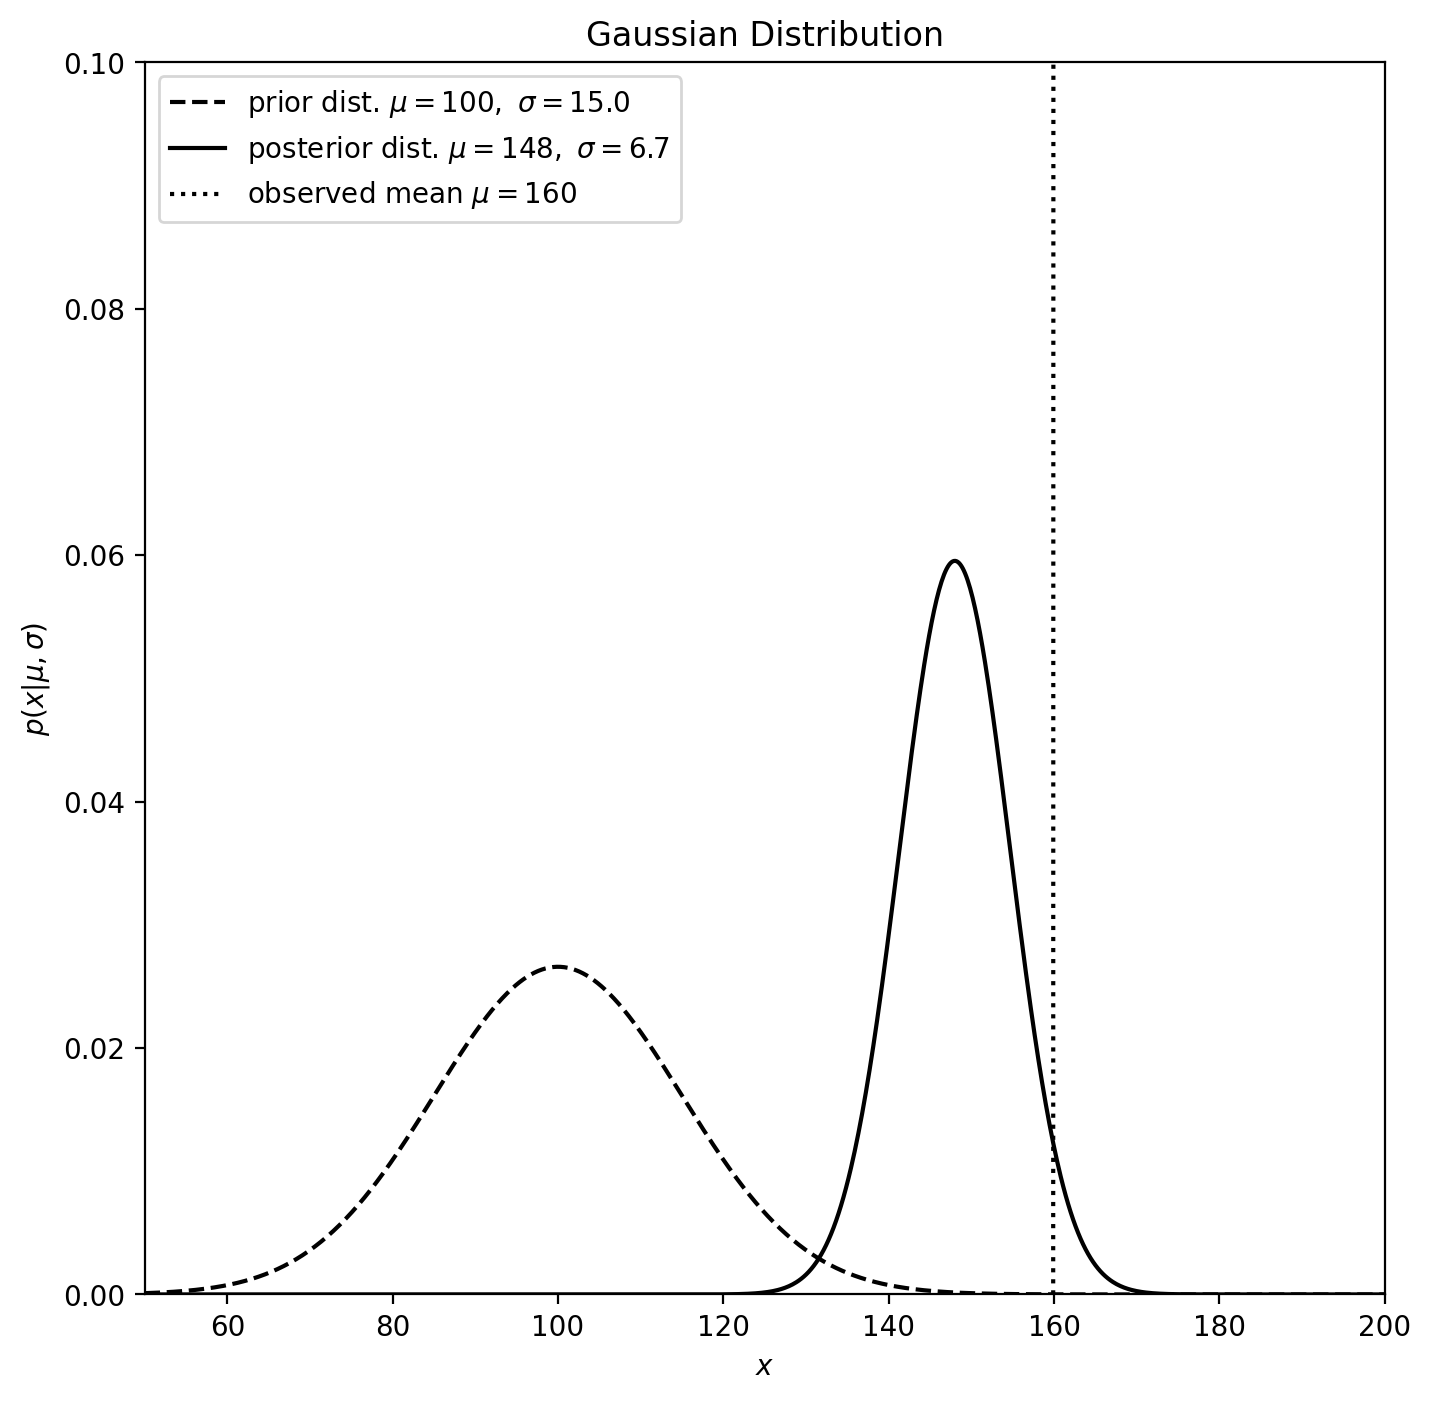

In [2]:
import numpy as np
from matplotlib import pyplot as plt

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats

#from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=10, usetex=True)

#------------------------------------------------------------
# Define the distributions to be plotted
sigma_values = [15, 6.7, 1] #complete with the prior width of IQ distribution
linestyles = ['--', '-', ':']
mu_values = [100, 148, 160] #complete with the prior mean of IQ distribution
labeltext = ['prior dist.', 
             'posterior dist.', 
             'observed mean']
xplot = np.linspace(50, 200, 1000)

#------------------------------------------------------------
# plot the distributions
fig, ax = plt.subplots(figsize=(8, 8))

for sigma, ls, mu, lab in zip(sigma_values, 
                              linestyles, 
                              mu_values, 
                              labeltext):
    
    # create a gaussian / normal distribution
    dist = norm(mu, sigma)

    if sigma > 1:
        plt.plot(xplot, dist.pdf(xplot), 
                 ls=ls, c='black',
                 label=r'%s $\mu=%i,\ \sigma=%.1f$' % (lab, mu, sigma))
    else:
        plt.plot([159.9, 160.1], [0, 0.8], 
                 ls=ls, color='k', label=r'%s $\mu=%i$' % (lab, mu))
        
plt.xlim(50, 200)
plt.ylim(0, 0.1)
plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu,\sigma)$')
plt.title('Gaussian Distribution')
plt.legend()
plt.show()

The end result (skipping over the detailed math) is that Alice's is not 160, but rather 148! More specifically, my Bayesian measurement is that $p(141.3\le \mu \le 154.7 \, | \, \overline{x}=160) = 0.683$ (i.e. there's a probability of 68% that Alice's IQ is between 141.3 and 154.7). This estimate incorporates not only the test I made to that person, but also the prior information of how the IQ distribution is calibrated. We already saw (remember the Monty Hall problem?) the huge influence that priors can have.

This all seems totally fine; where's the controvery with Bayesian methods? The controvery arises when we don't know the prior distribution (at least not explicitely! There's always a prior!), or when the parameter is fixed but we are trying to experimentally verify it (e.g., the speed of light).

### Coin flips 

Imagine you met a gambler who wanted you to **bet on whether the coin would come up heads or tails**. You watch the gambler work as a number of other people guess (as the coin is flipped). 


Remember the probability of getting $h$ heads in $n$ coin flips is given by the binomial probability distribution
>$P(h|\theta) = \theta^h (1-\theta)^{(n-h)}$

with $\theta$ the probability of a head.

We want to calculate and plot the Bayesian posterior of the probabilty of drawing a head as a function of watching [5, 50, 500] coin flips.

Ok so:

* formulate the likelihood, $p(D\,|\,M,\theta,I)$
* choose a prior
* plot the posterior pdf, $p(M,\theta \,|\,D,I)$

Ideas?




In [3]:
# Execute this cell for some data to use
data = np.array([
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1])

In [4]:
len(data), np.sum(data==0), np.sum(data==1)

(500, 144, 356)

I don't know anything about this gambler, so I'll take a uniform prior.

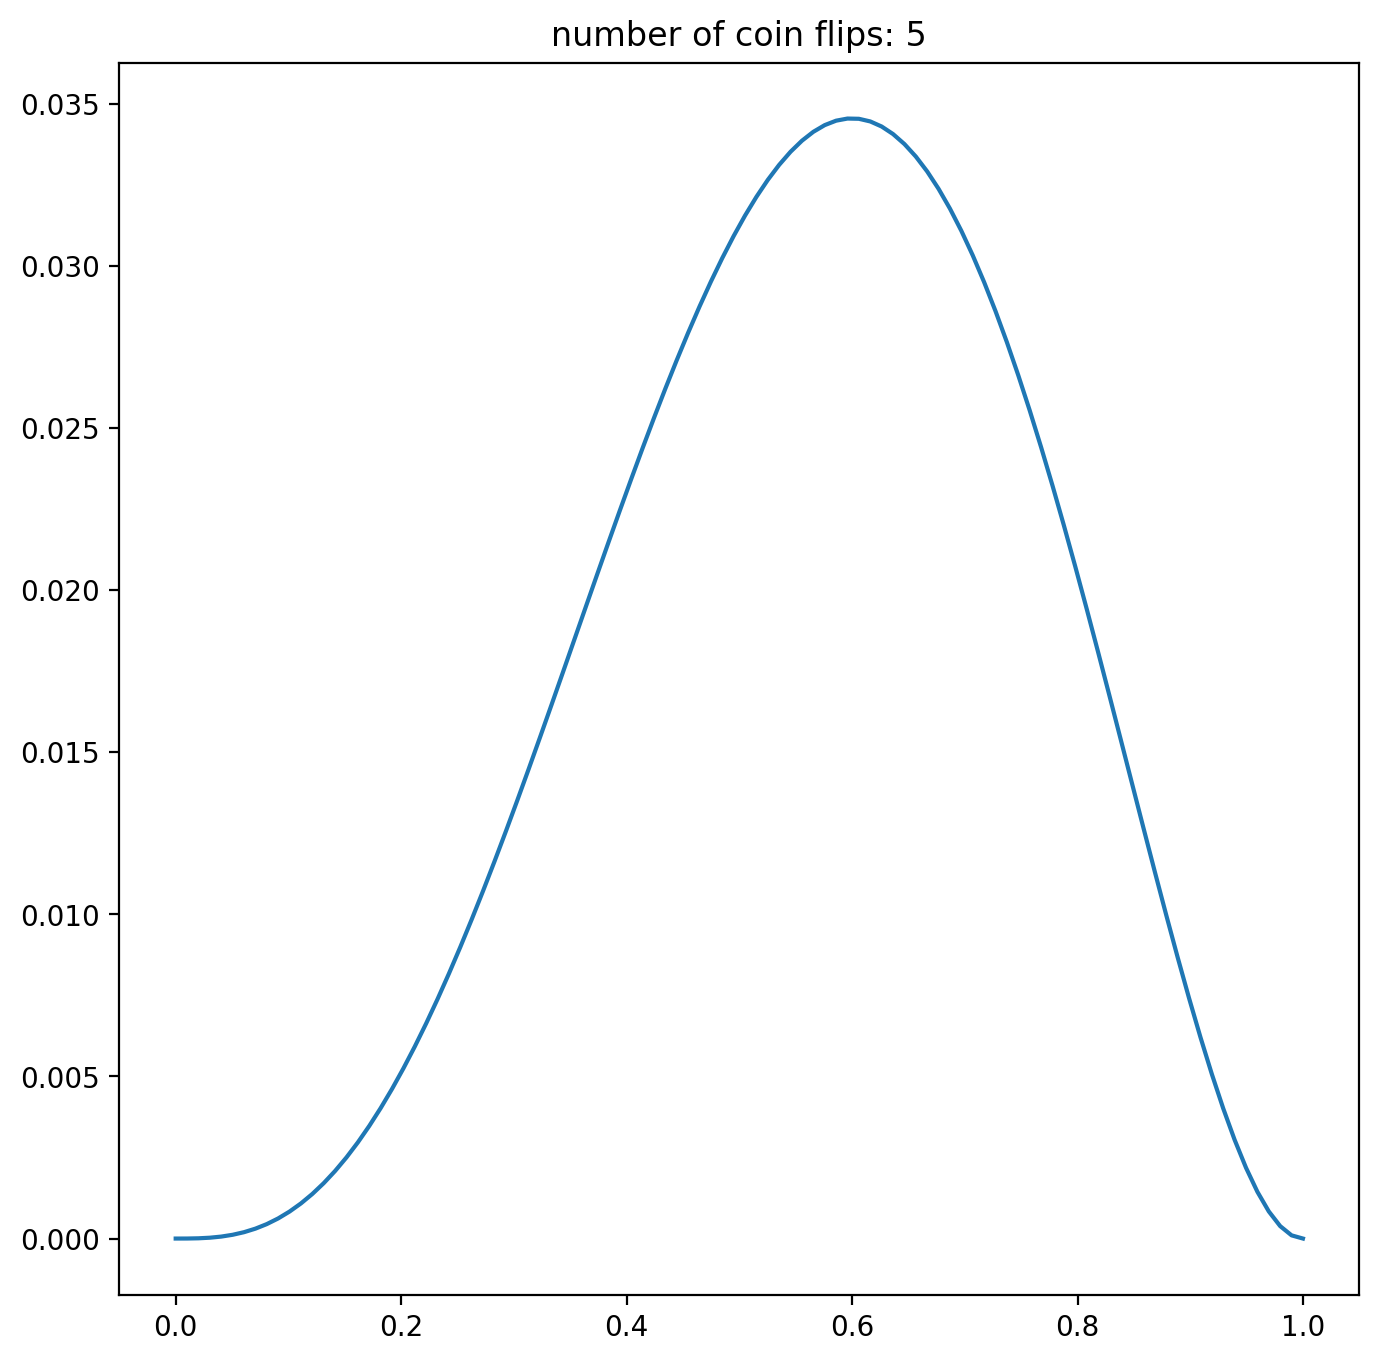

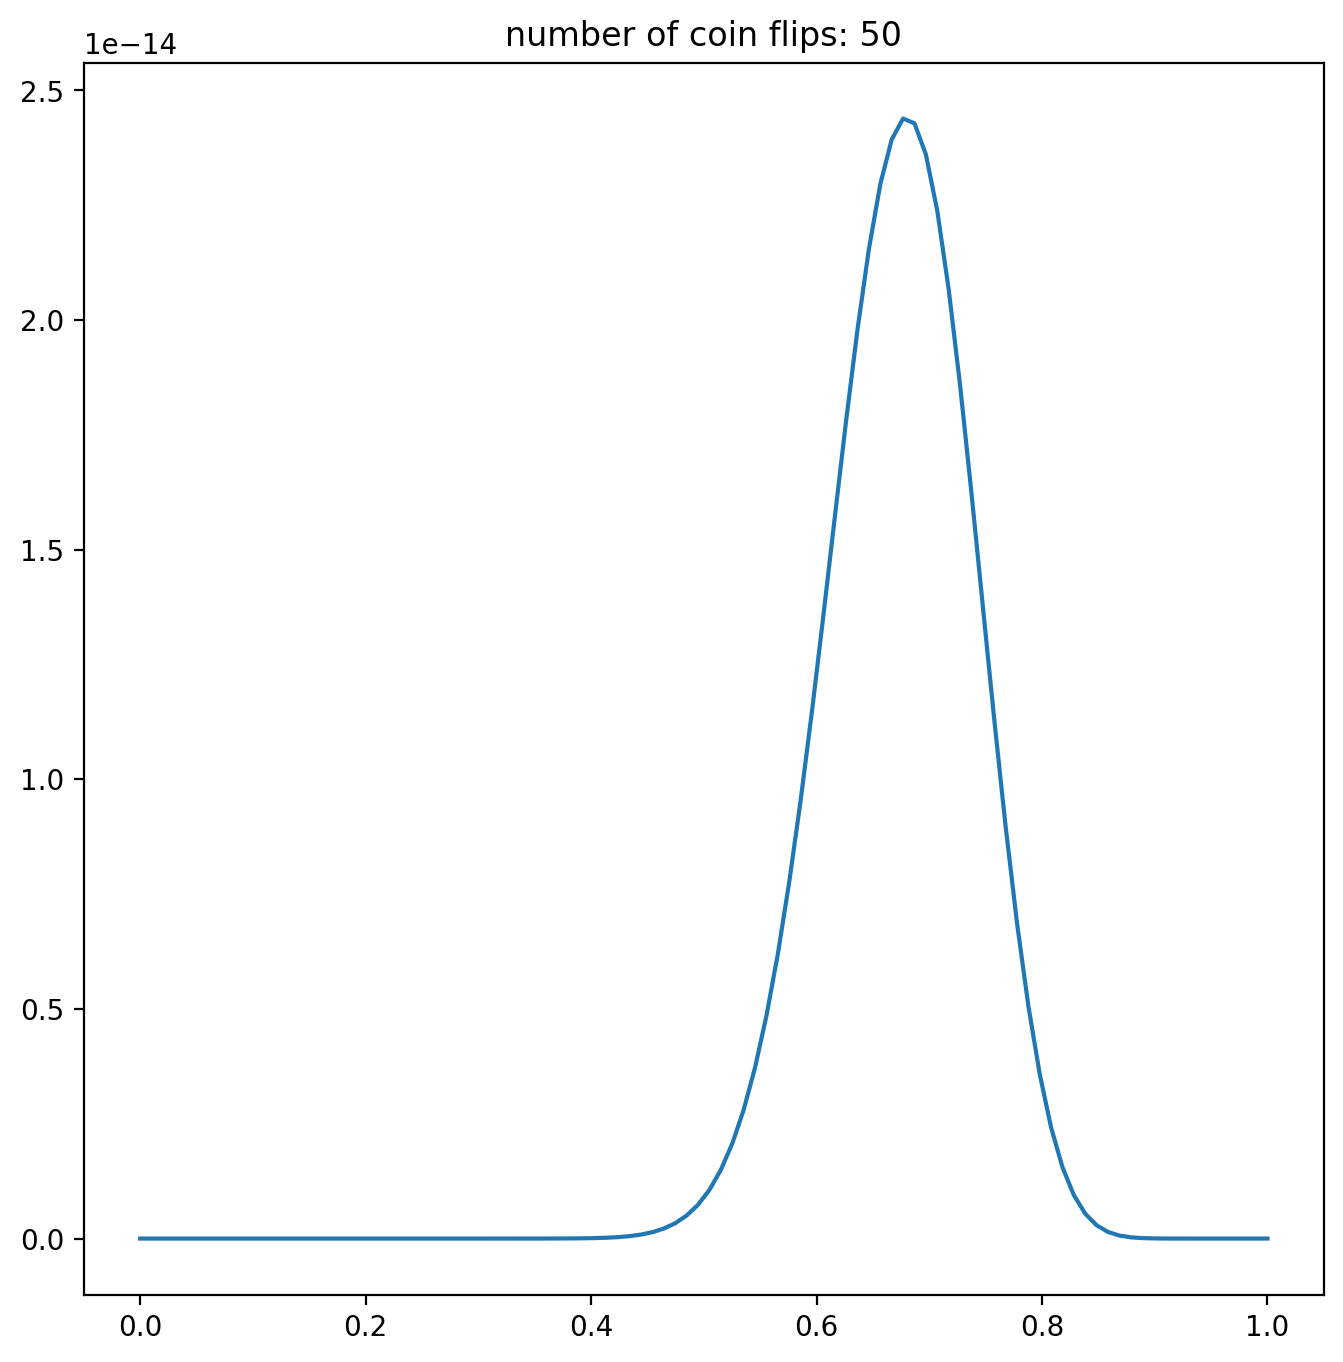

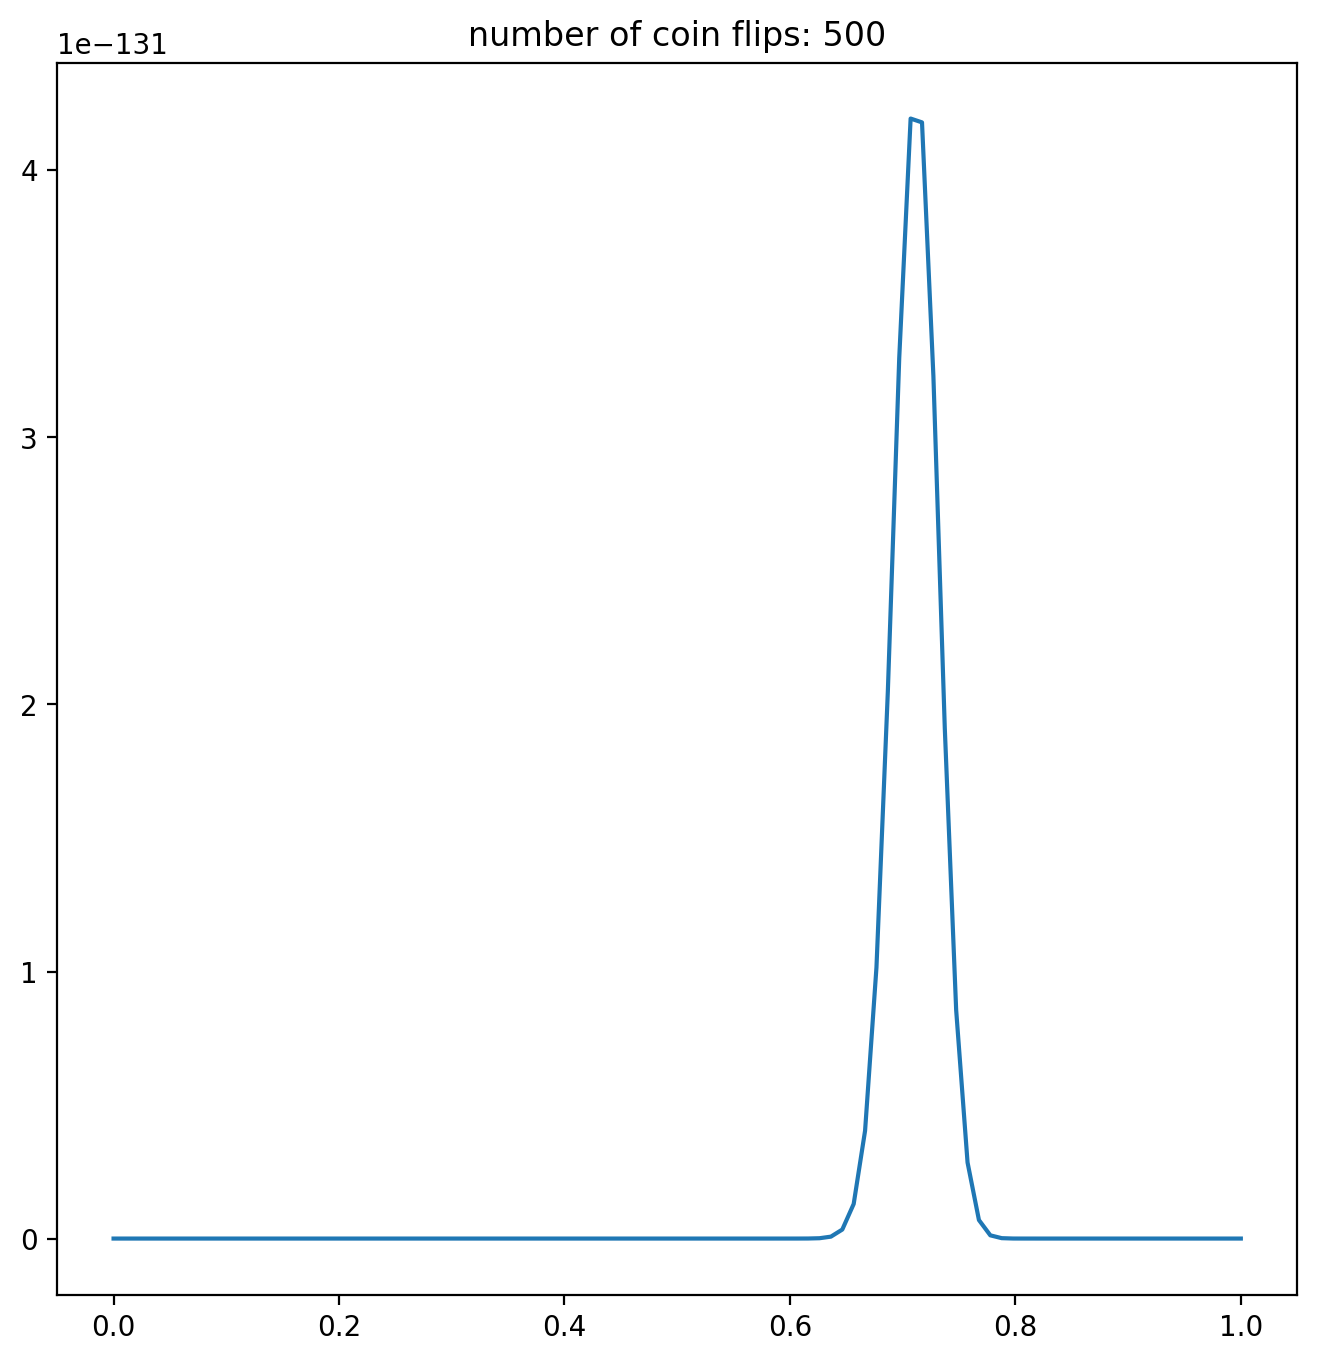

In [5]:
def p_nheads(n, h, theta):
    return (theta**h) * ((1-theta)**(n-h))

# likelihood
def L(data, ntrials, theta):
    nheads = data[:ntrials].sum()
    return p_nheads(ntrials, nheads, theta)

# prior. Just uniform?
def prior(theta):
    return 1

probs = []
# define the number of trials
n_trials = [5, 50, 500]
theta = np.linspace(0, 1, 100)
for nt in n_trials:
    prob = L(data, nt, theta) * prior(theta)
    # posterior plot
    plt.plot(theta, prob, 
            label=r'ntrial = '+str(nt))
    # likelihood plot
    #plt.plot(theta, L(data, nt, theta))
    plt.title("number of coin flips: "+str(nt))  
    plt.show()


Careful that we're not tracking the normalization! But that's ok. We can trivially normalize the curve if we need it (most times we don't...)

Say you know this gambler already. What if I used a $\beta$ function for the prior?

$P(\alpha, \beta, \theta) = \theta^{\alpha-1} (1-\theta)^{(\beta-1)}$


![](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Beta_distribution_pdf.svg/1200px-Beta_distribution_pdf.svg.png)

Let's use a $\beta$ function prior on $\theta$ with $\alpha=2$ and $\beta=5$. You can code this directly or grab from `scipy.stats`.

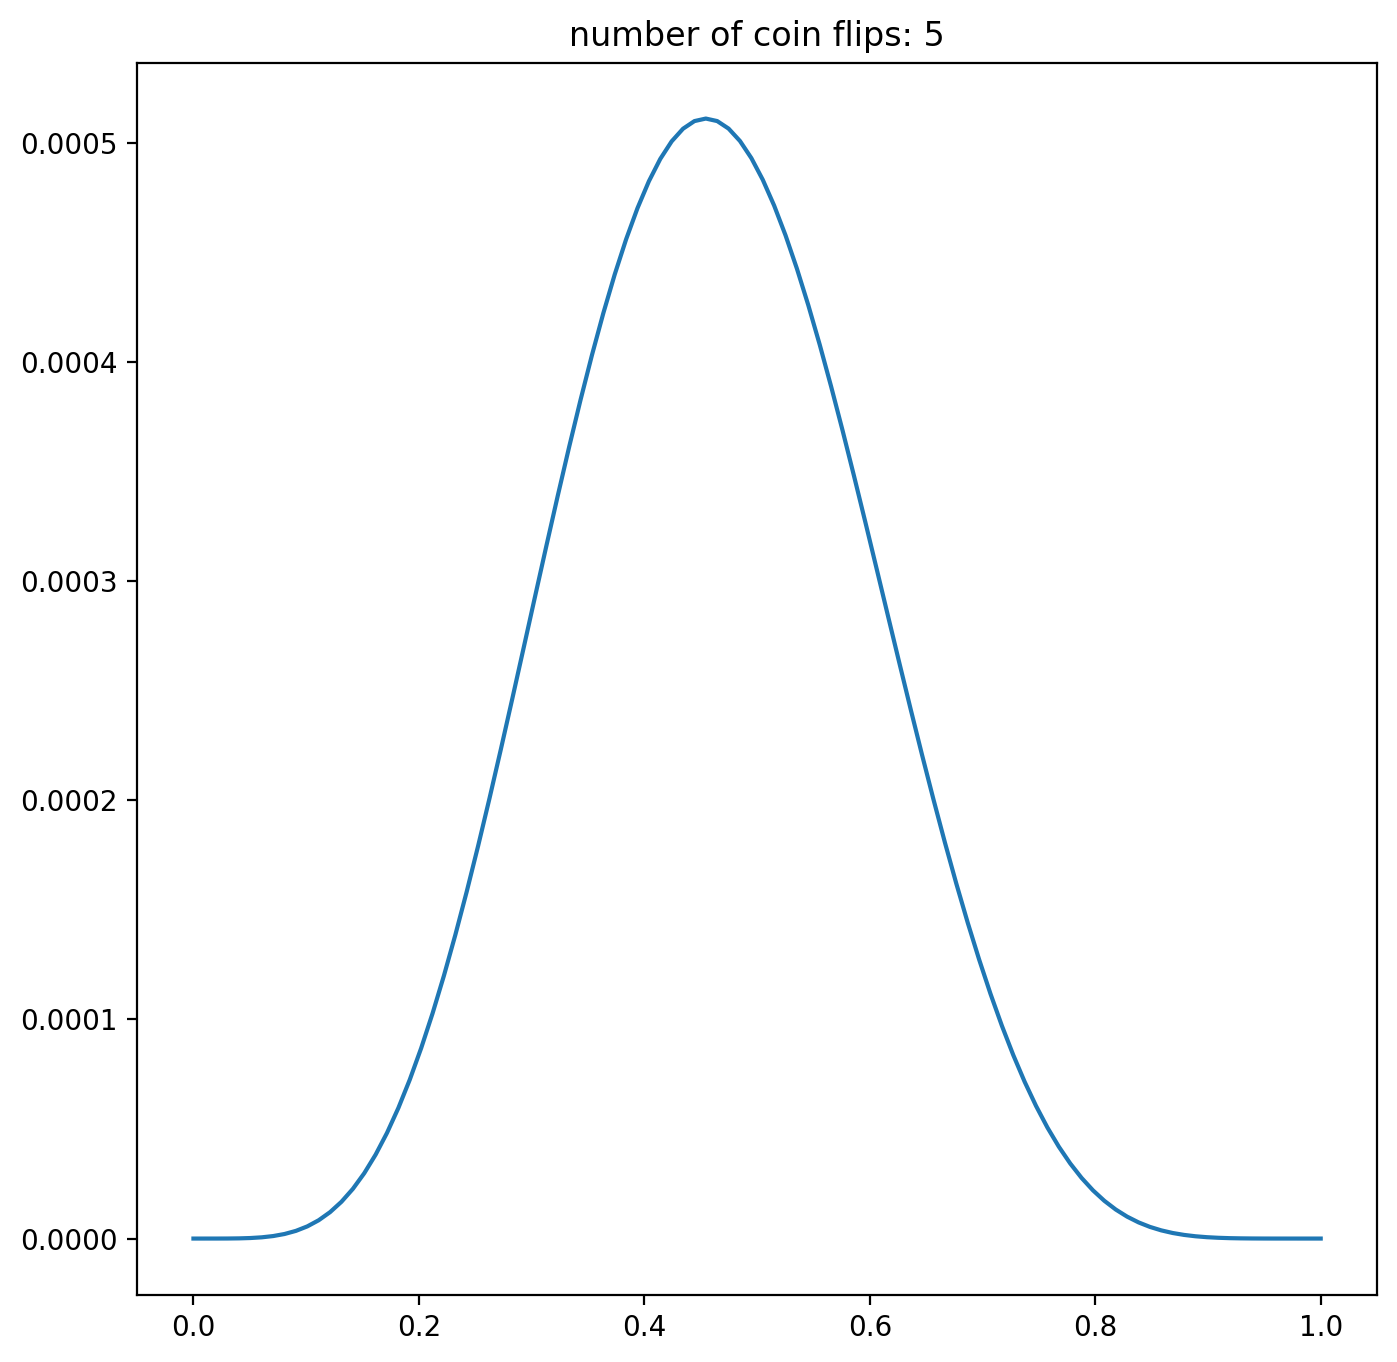

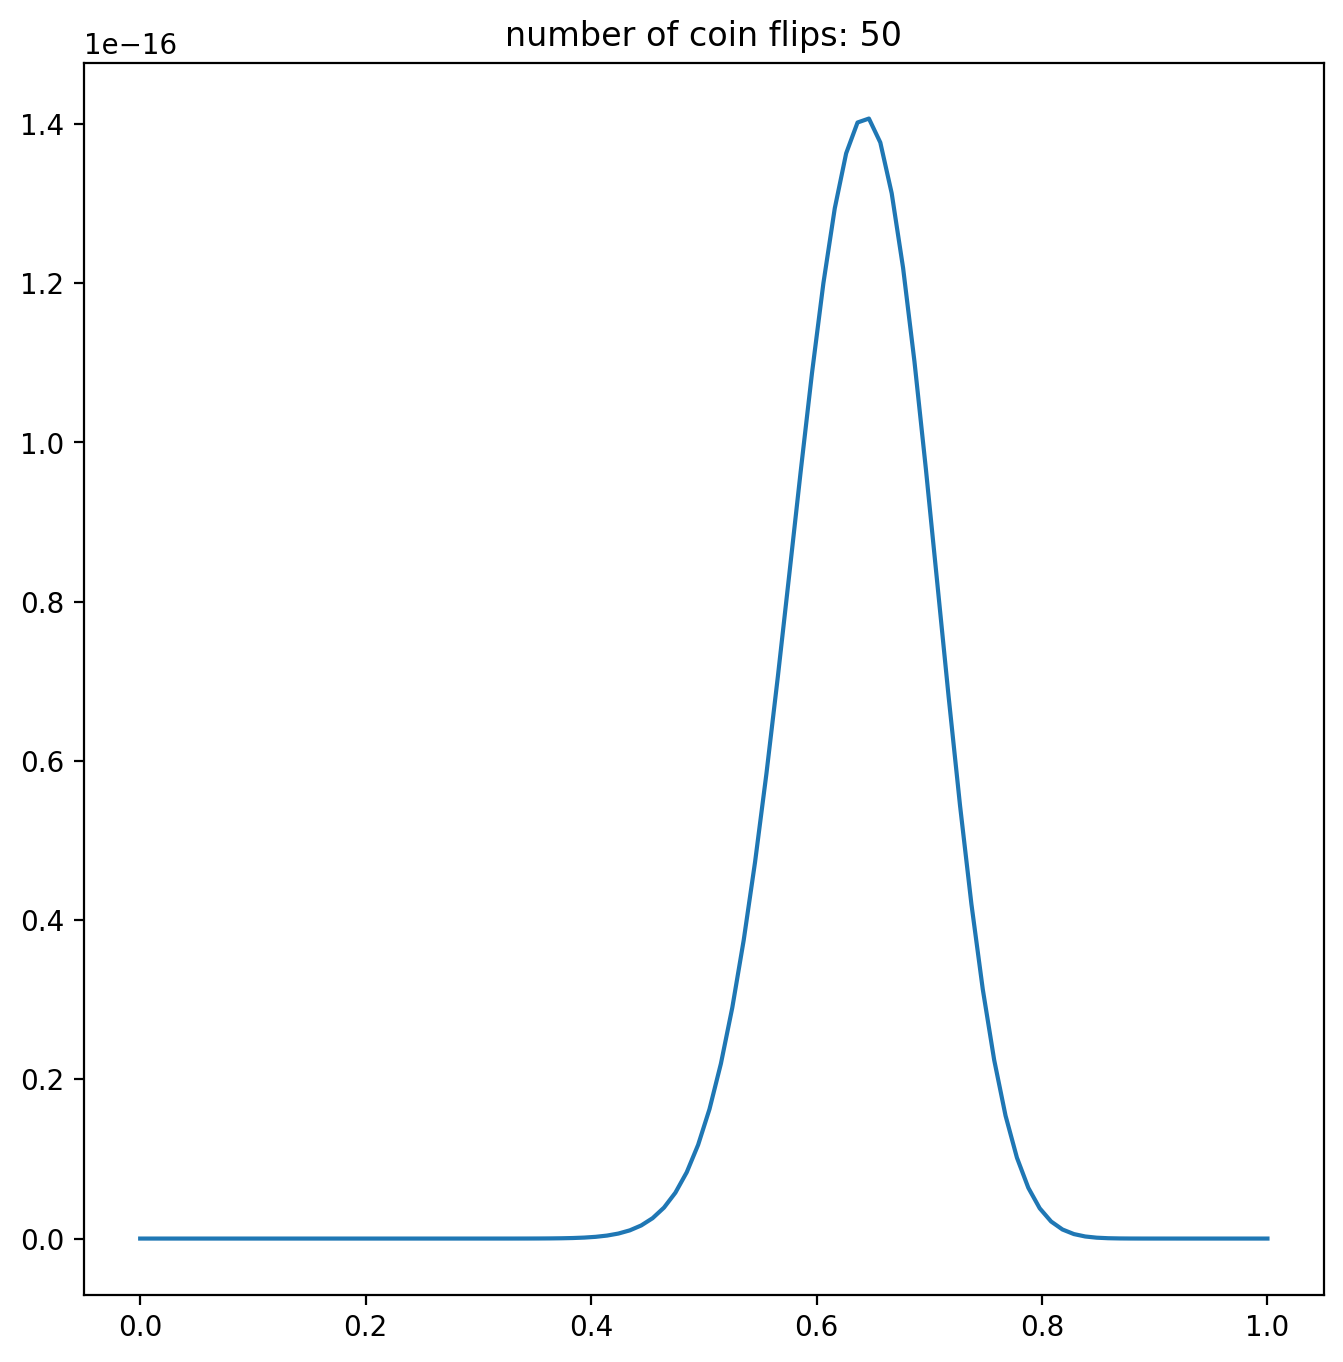

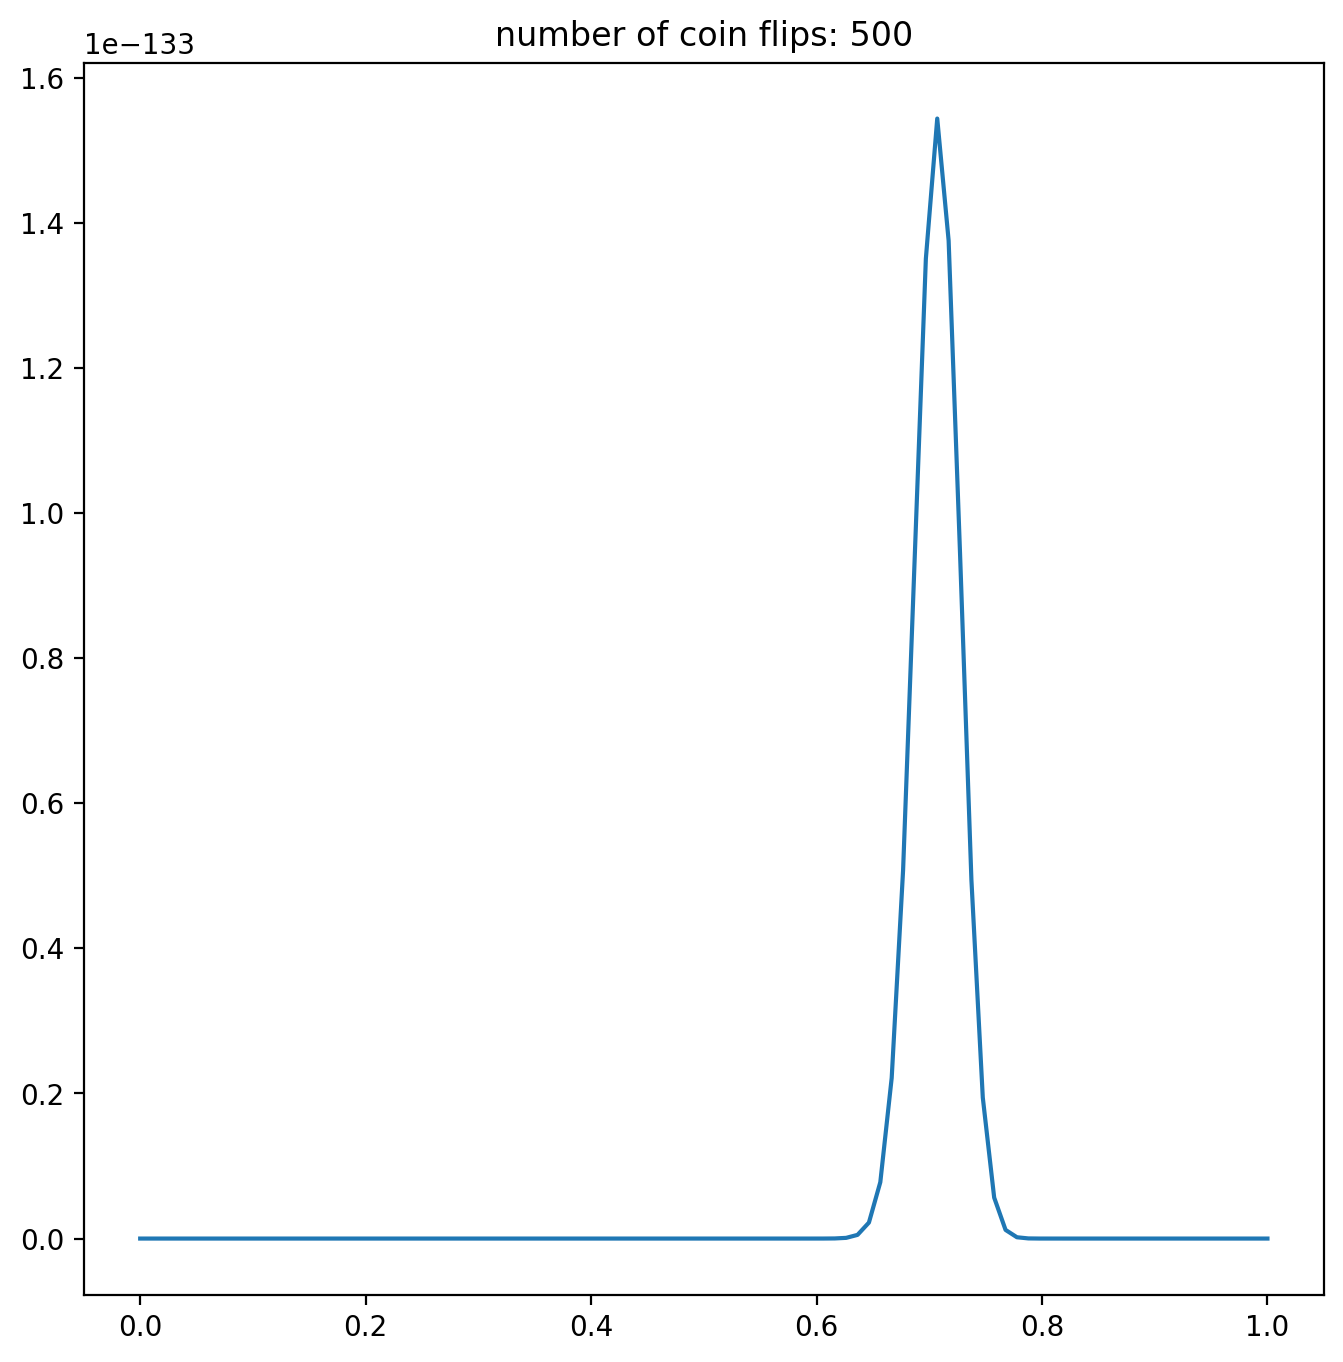

In [6]:
# Modify and execute this cell.

def p_nheads(n, h, theta):
    return (theta**h) * ((1-theta)**(n-h))

# likelihood
def L(data, ntrials, theta):
    nheads = data[:ntrials].sum()
    return p_nheads(ntrials, nheads, theta)

def prior(theta):
    alpha=2
    beta=5
    return  (theta**alpha) * ((1-theta)**(beta-1))

probs = []
# define the number of trials
n_trials = [5, 50, 500]
theta = np.linspace(0, 1, 100)
for nt in n_trials:
    prob = L(data, nt, theta) * prior(theta)
    # posterior plot
    plt.plot(theta, prob, 
            label=r'ntrial = '+str(nt))
    # likelihood plot
    #plt.plot(theta, L(data, nt, theta))
    plt.title("number of coin flips: "+str(nt))  
    plt.show()

The first case is different, the last one is not. As the amount of data increases, inference becomes data driven and the chosen prior is less important. Often we don't have this luxury!

About coins, this is a super fun recent paper [https://arxiv.org/abs/2310.04153](https://arxiv.org/abs/2310.04153) 

# Pdfs and samples

We've seend that we have probability distribution $p(x)$ as well as samples from that distribution $\{x_i\}$. 
Given a datapoint $x$, if you have the pdf you can just evaluate $p(x)$. Samples instead are such that their *density* contains information on the pdf.

(Pause for a second here and make sure you understand this difference; it's very important for everything that comes next in this class!)

Before going into more complicated things, there are two typical tasks we will often meet:

1. You have the pdf and want to extract samples from it;
2. You have the samples and want to estimate the pdf.


# Action 1. Sampling strategies (i.e. going from the pdf to the samples)

The task here is that I have a pdf and want to extract numbers such that their density is informative of that pdf (i.e. there should be more values where the pdf is large and fewer where the pdf is small)

## Method 0. The easy way


For some canonical, easy distributions, that's already been implemented by someone else. For instance for a gaussian:

In [7]:
import scipy.stats
import numpy as np
import pylab as plt

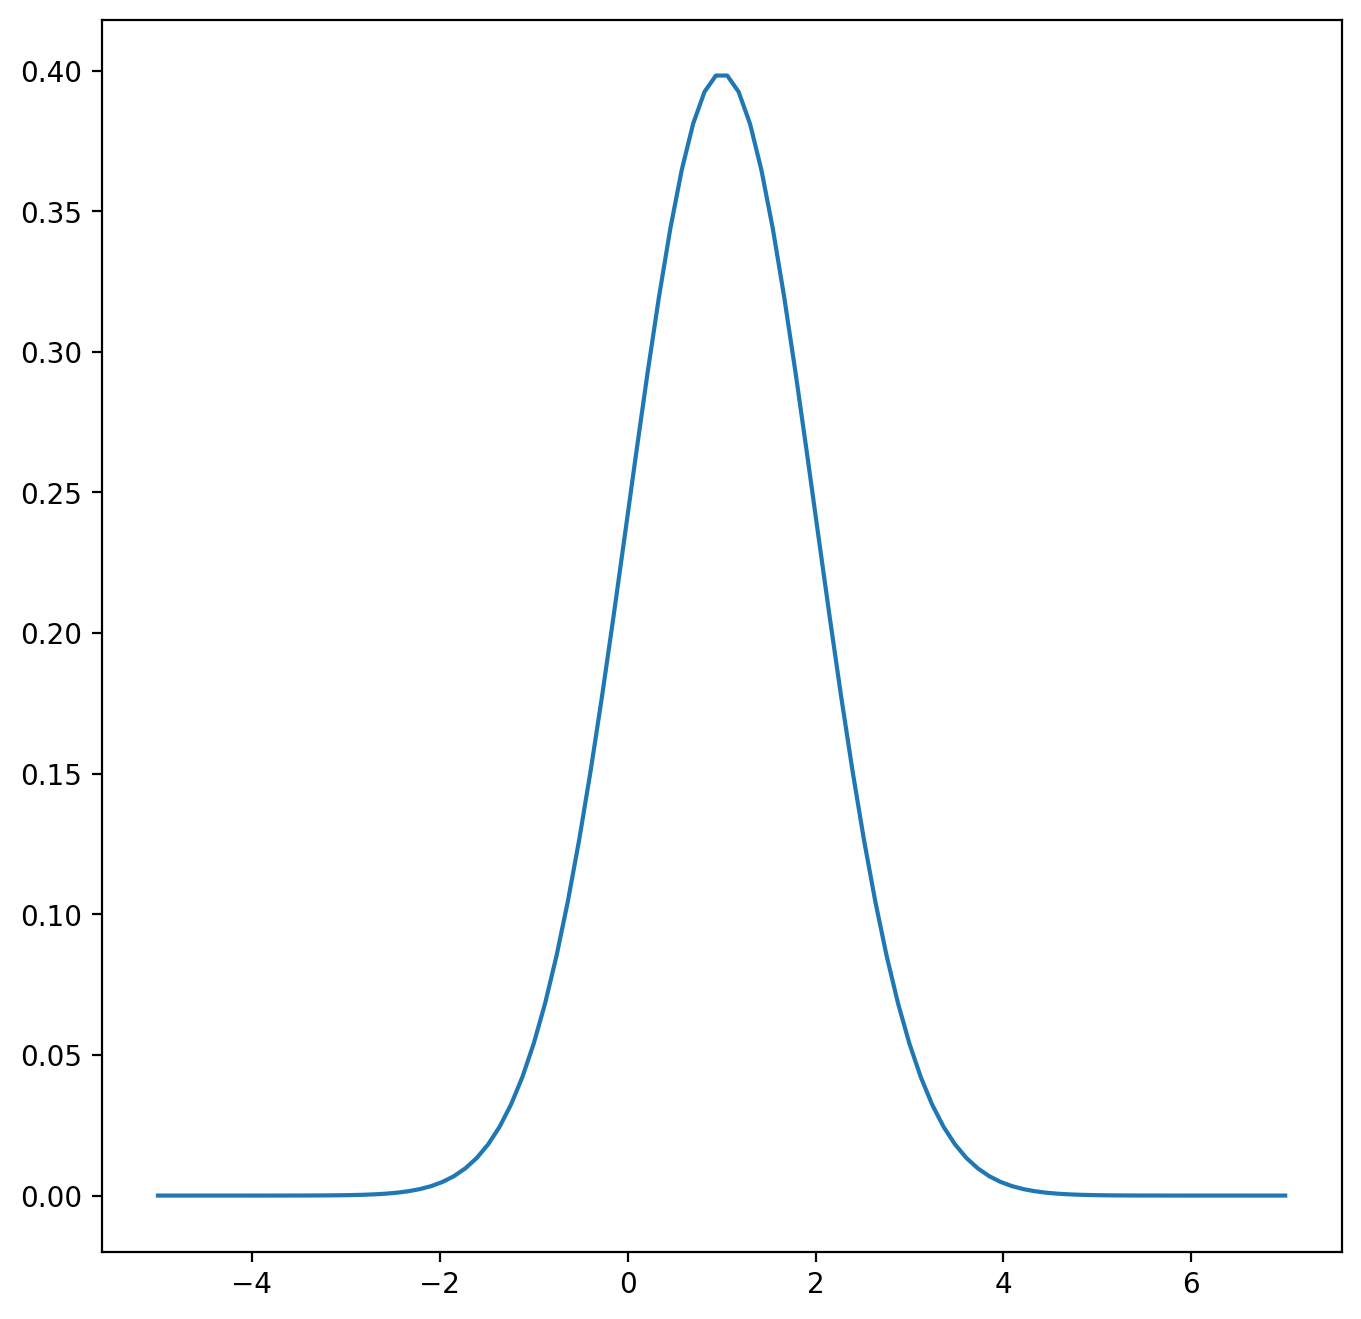

In [8]:
gaussian=scipy.stats.norm(loc=1,scale=1)

x = np.linspace(-5,7,100)
plt.plot(x,gaussian.pdf(x))

Extracting points is as wasy as

In [9]:
samples = gaussian.rvs(100000);
print(samples)

[0.54666813 2.96181999 0.86346627 ... 2.3677153  1.93410087 1.16796023]


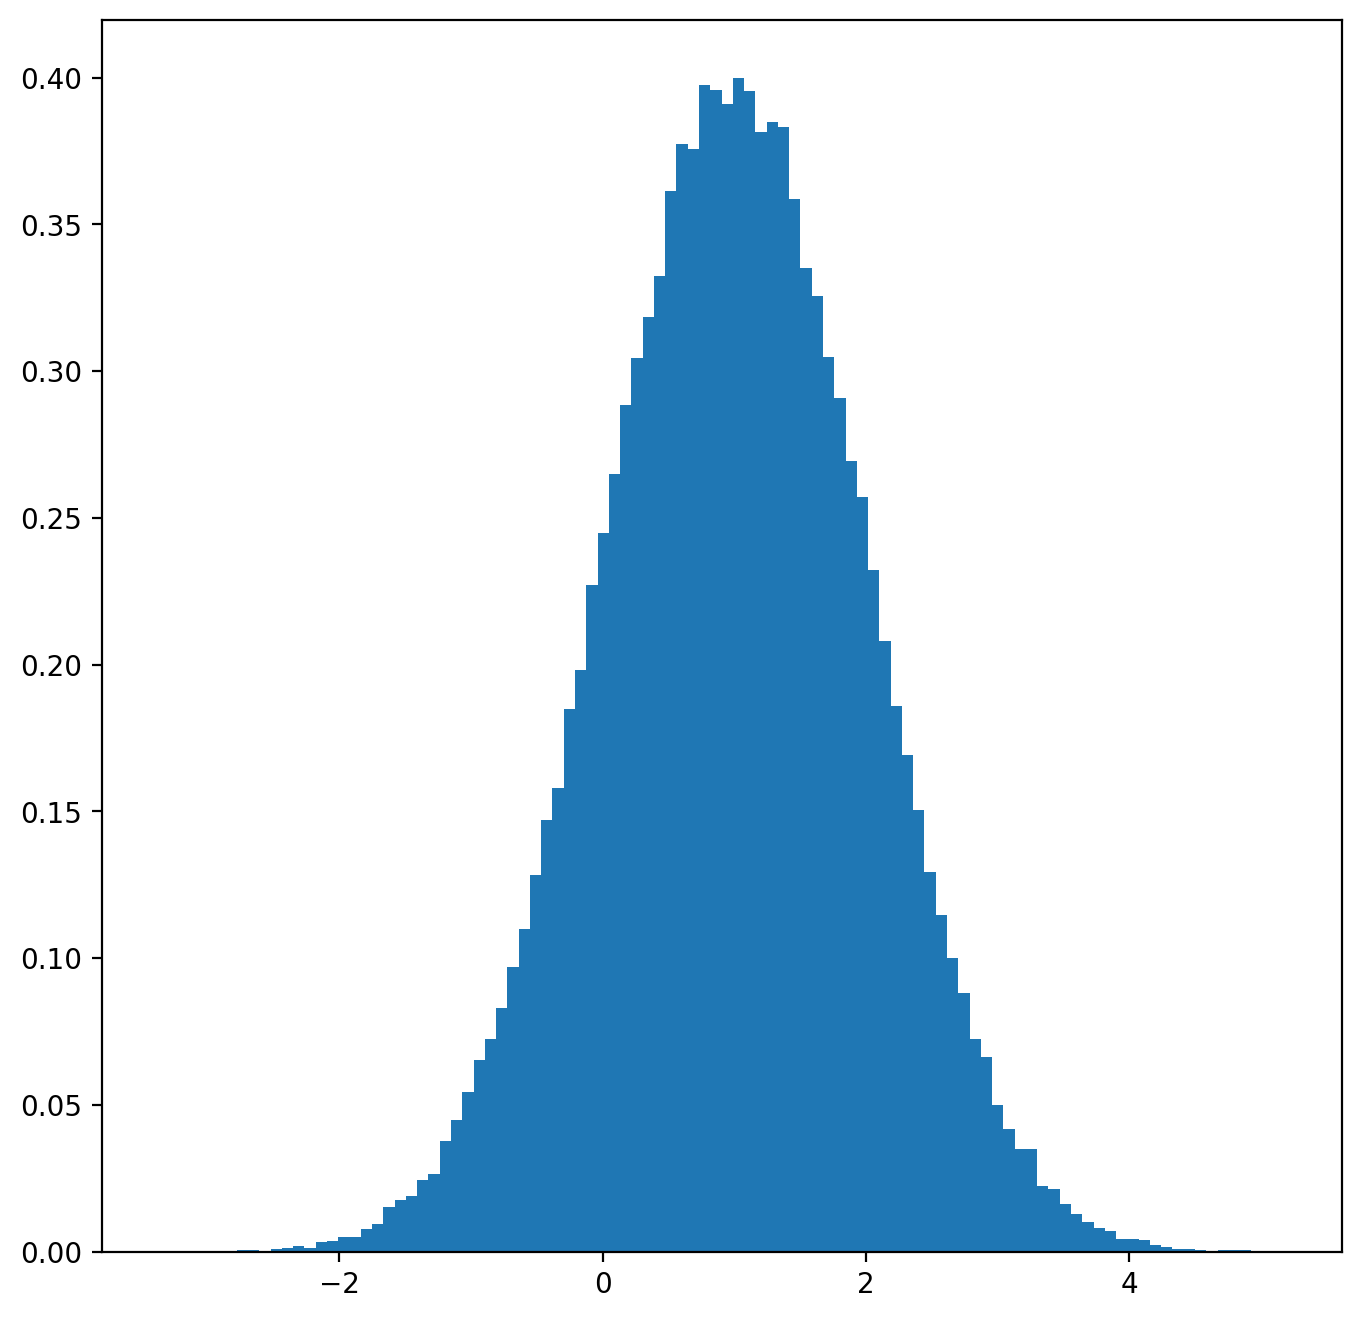

In [10]:
samples = gaussian.rvs(100000);


plt.hist(samples,bins=100,density=True);

This is so easy, but of course it doesn't work for arbitrary pdfs! Only for some standard distributions that someone has implemented.

## Method 1. Rejection sampling

The process for sampling from an arbitrary distribution with rejection is:

1) Decide on a straightforward *proposal distribution* $q(x)$ to propose new samples. It should be wide enough to capture the tails of $h(x)$. We'll use a uniform distribution here.

2) Generate a random sample from $q(x)$, $x_i$.

3) Now generate a random sample, $u$, from a uniform distribution in the range $[0,\mathrm{max}(h(x))]$, where the upper bound should be as large or larger than the maximum density of $h(x)$. (This could be worked out analytically or by histograming the data.)

4) If $u\leq h(x_i)$ accept the point, or else reject it and try again from step 2.


This is shown pictorally here (image reproduced by [Robert Collins class CSE586 "Computer Vision II" at PSU](http://www.cse.psu.edu/~rtc12/CSE586/))

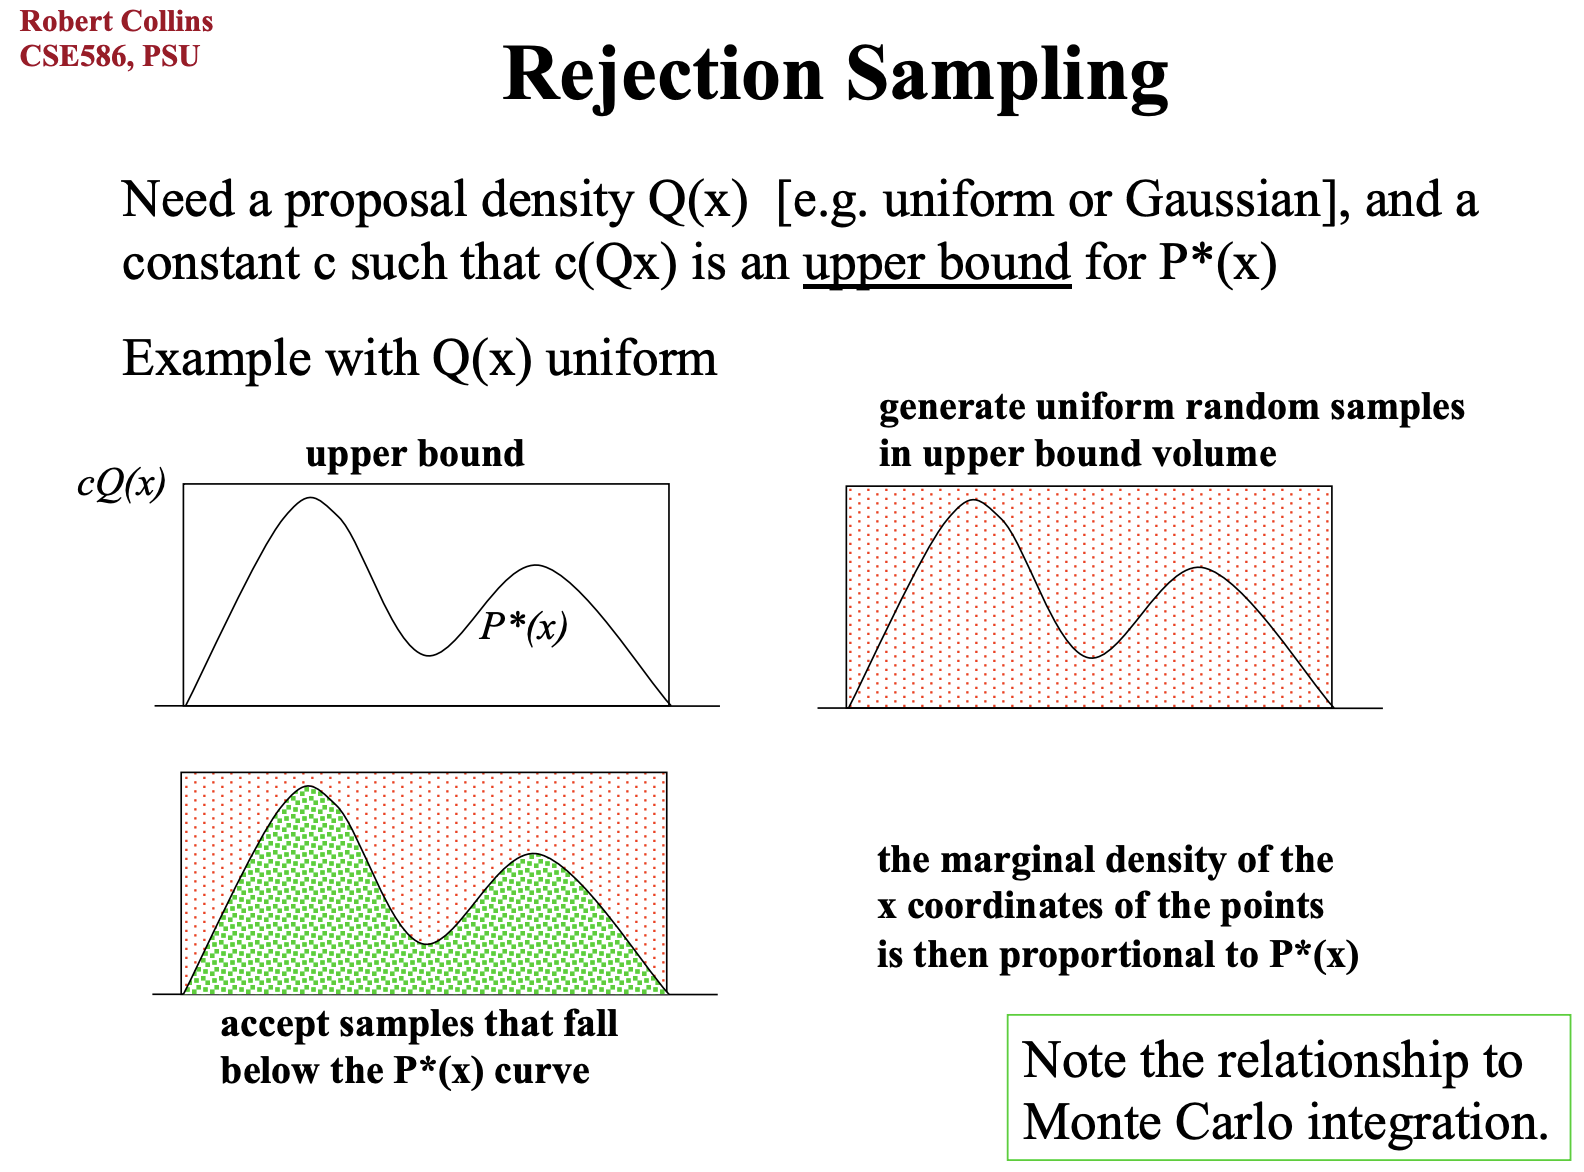

Let's try this for a simple case. Sample from $$p(x)\propto x+sin(x)$$ between 0 and 10

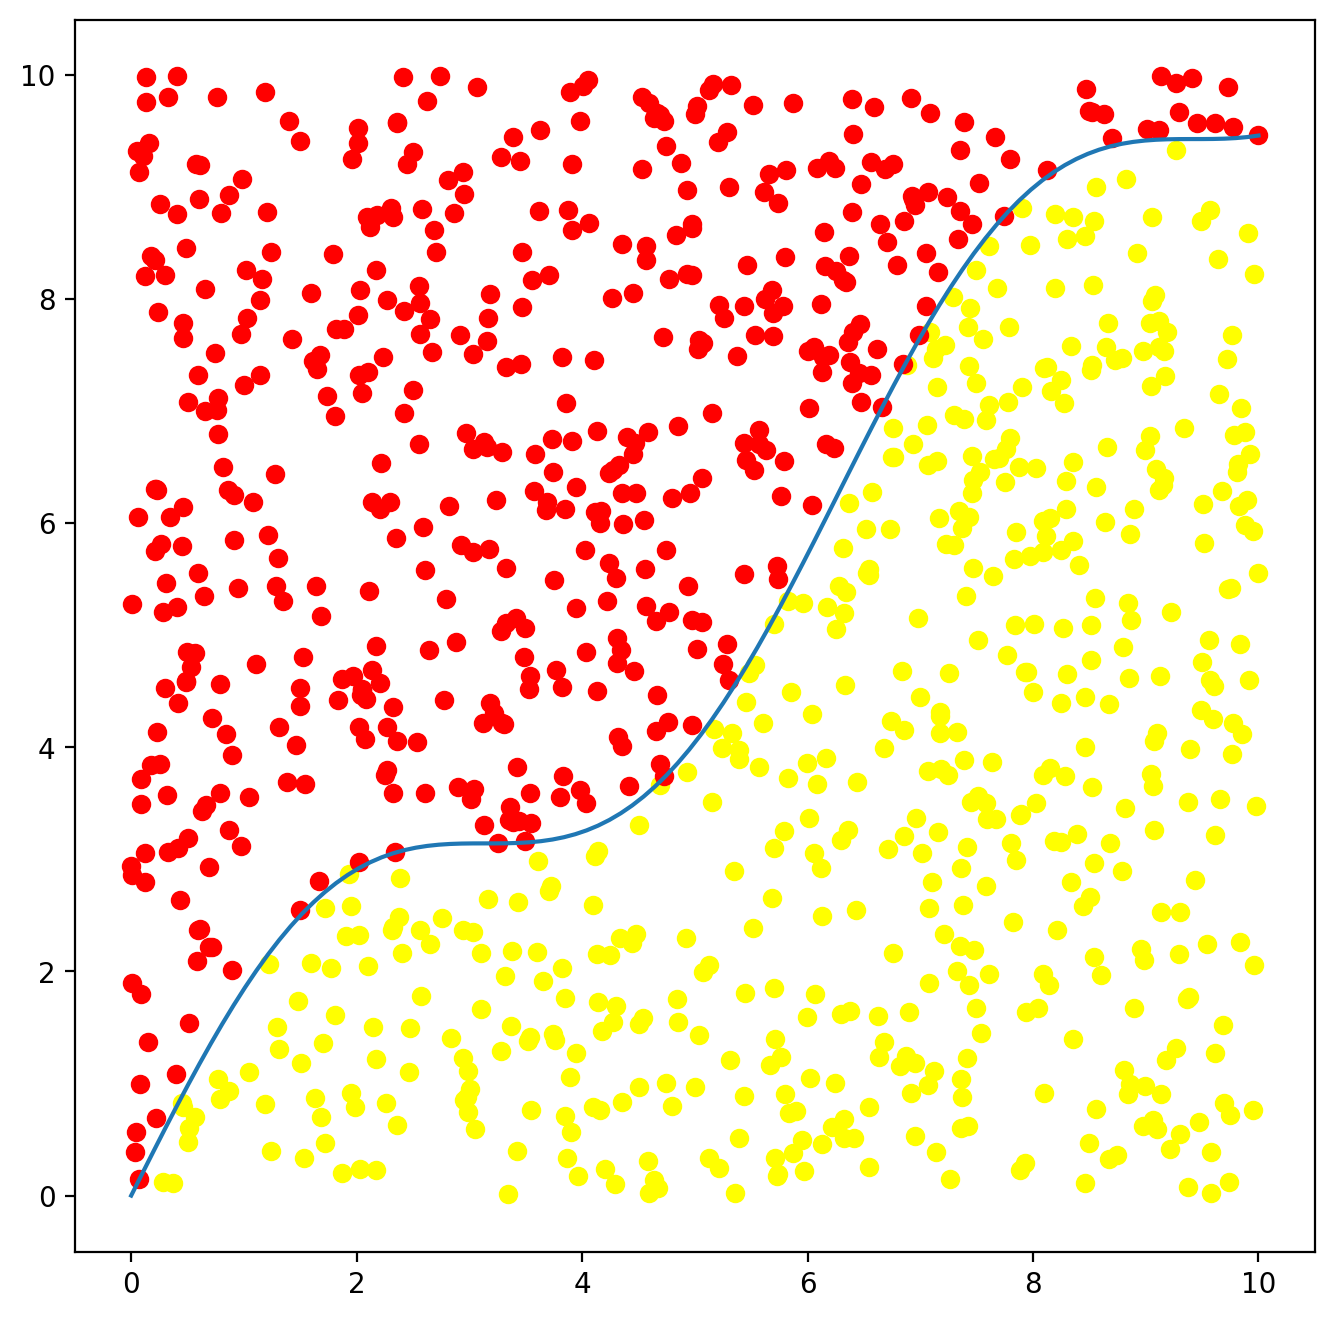

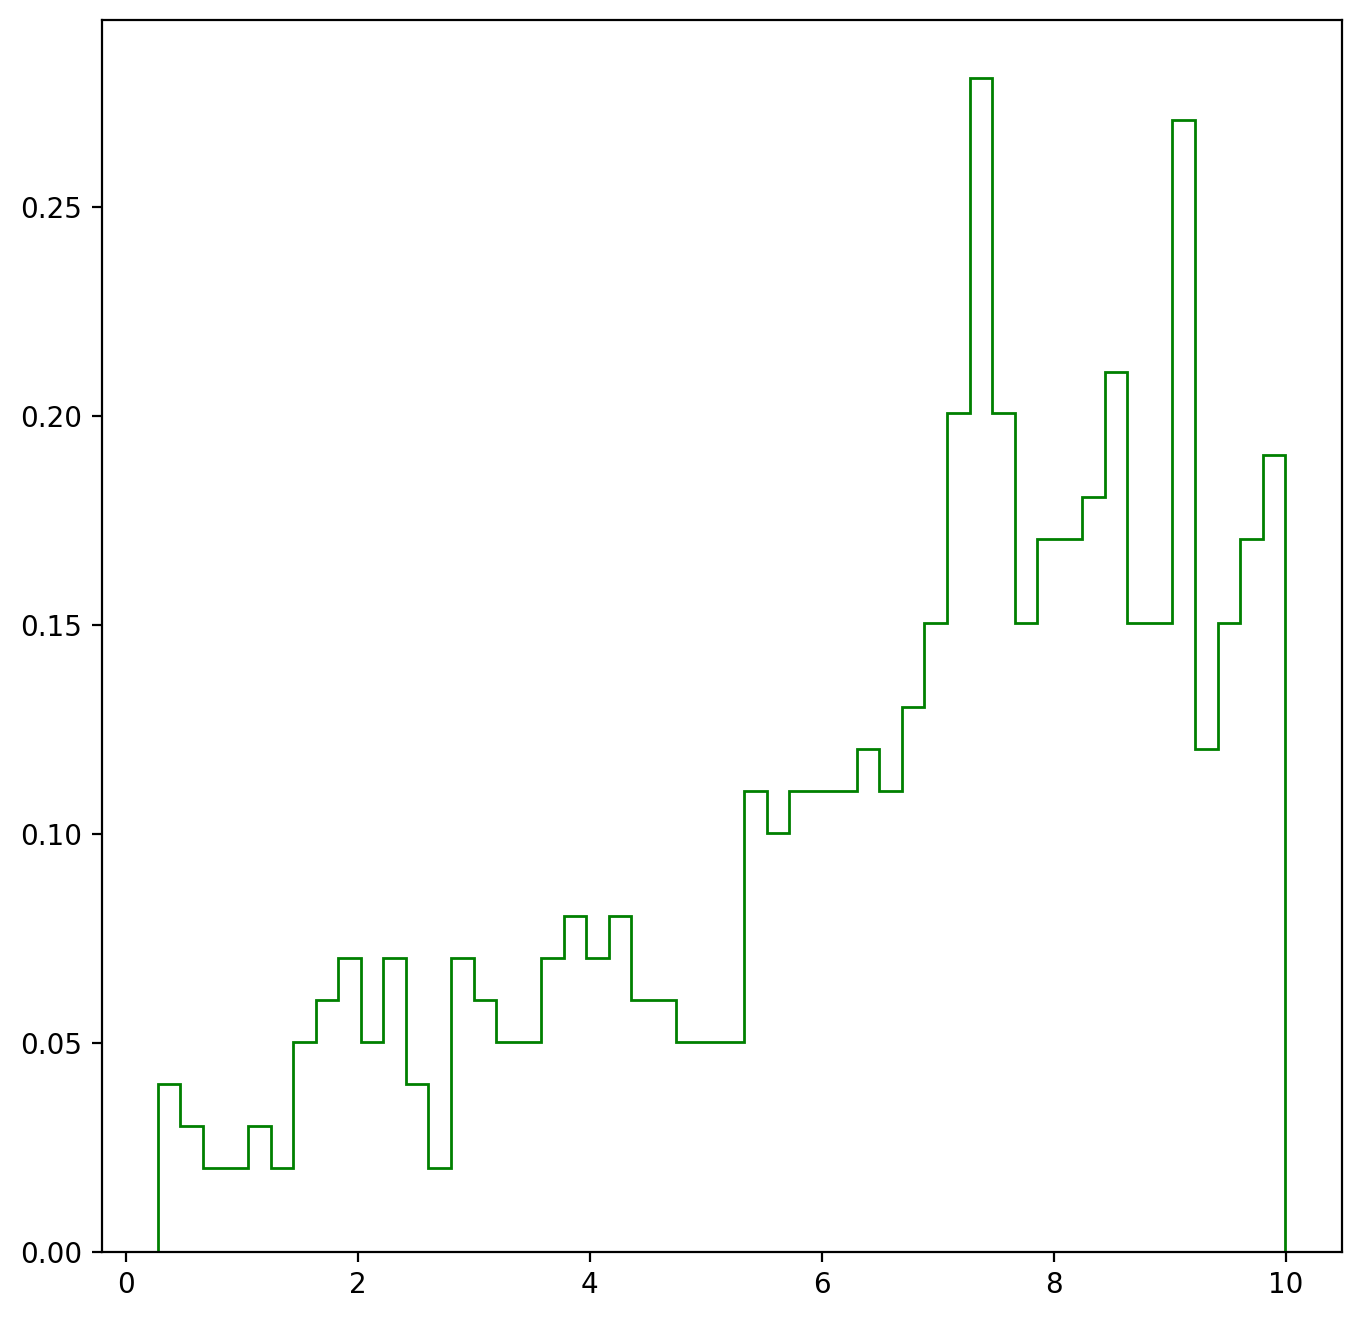

In [11]:
f = lambda x: x+np.sin(x)  # pause and look at how great lambda functions are! 

N=1000

xg = np.linspace(0,10,100)

plt.plot(xg,f(xg))


ymax = 10
x = np.random.uniform(0,10,N)
y = np.random.uniform(0,ymax,N)


plt.scatter(x[y<f(x)],y[y<f(x)],c='yellow')
plt.scatter(x[y>f(x)],y[y>f(x)],c='red')

plt.show()
goodpoints = x[y<f(x)]


plt.hist(goodpoints,bins=50,density=True,histtype='step',color='green');


## Method 2.  Inverse transform sampling

Rejection sampling works, but wouldn't it be awesome if we didn't have to discard *any* points during our sampling? This is the power and simplicity of **inverse transform sampling**. The process is exceedingly simple. 

1) To sample from an arbitrary $h(x)$, you will also need the cdf $H(x)$ and its inverse, the quantile function $H^{-1}(x)$. If $h(x)$ is difficult to integrate, or $H(x)$ is difficult to invert to get the quantile function, then you could use numerical techniques to interpolate or produce lookup tables.

2) Generate a random sample $u$ from a uniform random distribution $[0,1]$. 

3) Using the quantile function $H^{-1}(x)$, find the value of $x$ below which a fraction $u$ of the distribution is contained. 

4) The $x$ value you get is a random sample from $h(x)$. Easy, right?


/Users/dgerosa/box/lib/python3.11/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_32371/3544168984.py:54: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  x = np.hstack((d.rvs(int(f * Ndata)) for d, f in zip(dists, fracs)))


KS test: D = 0.0028; p = 1


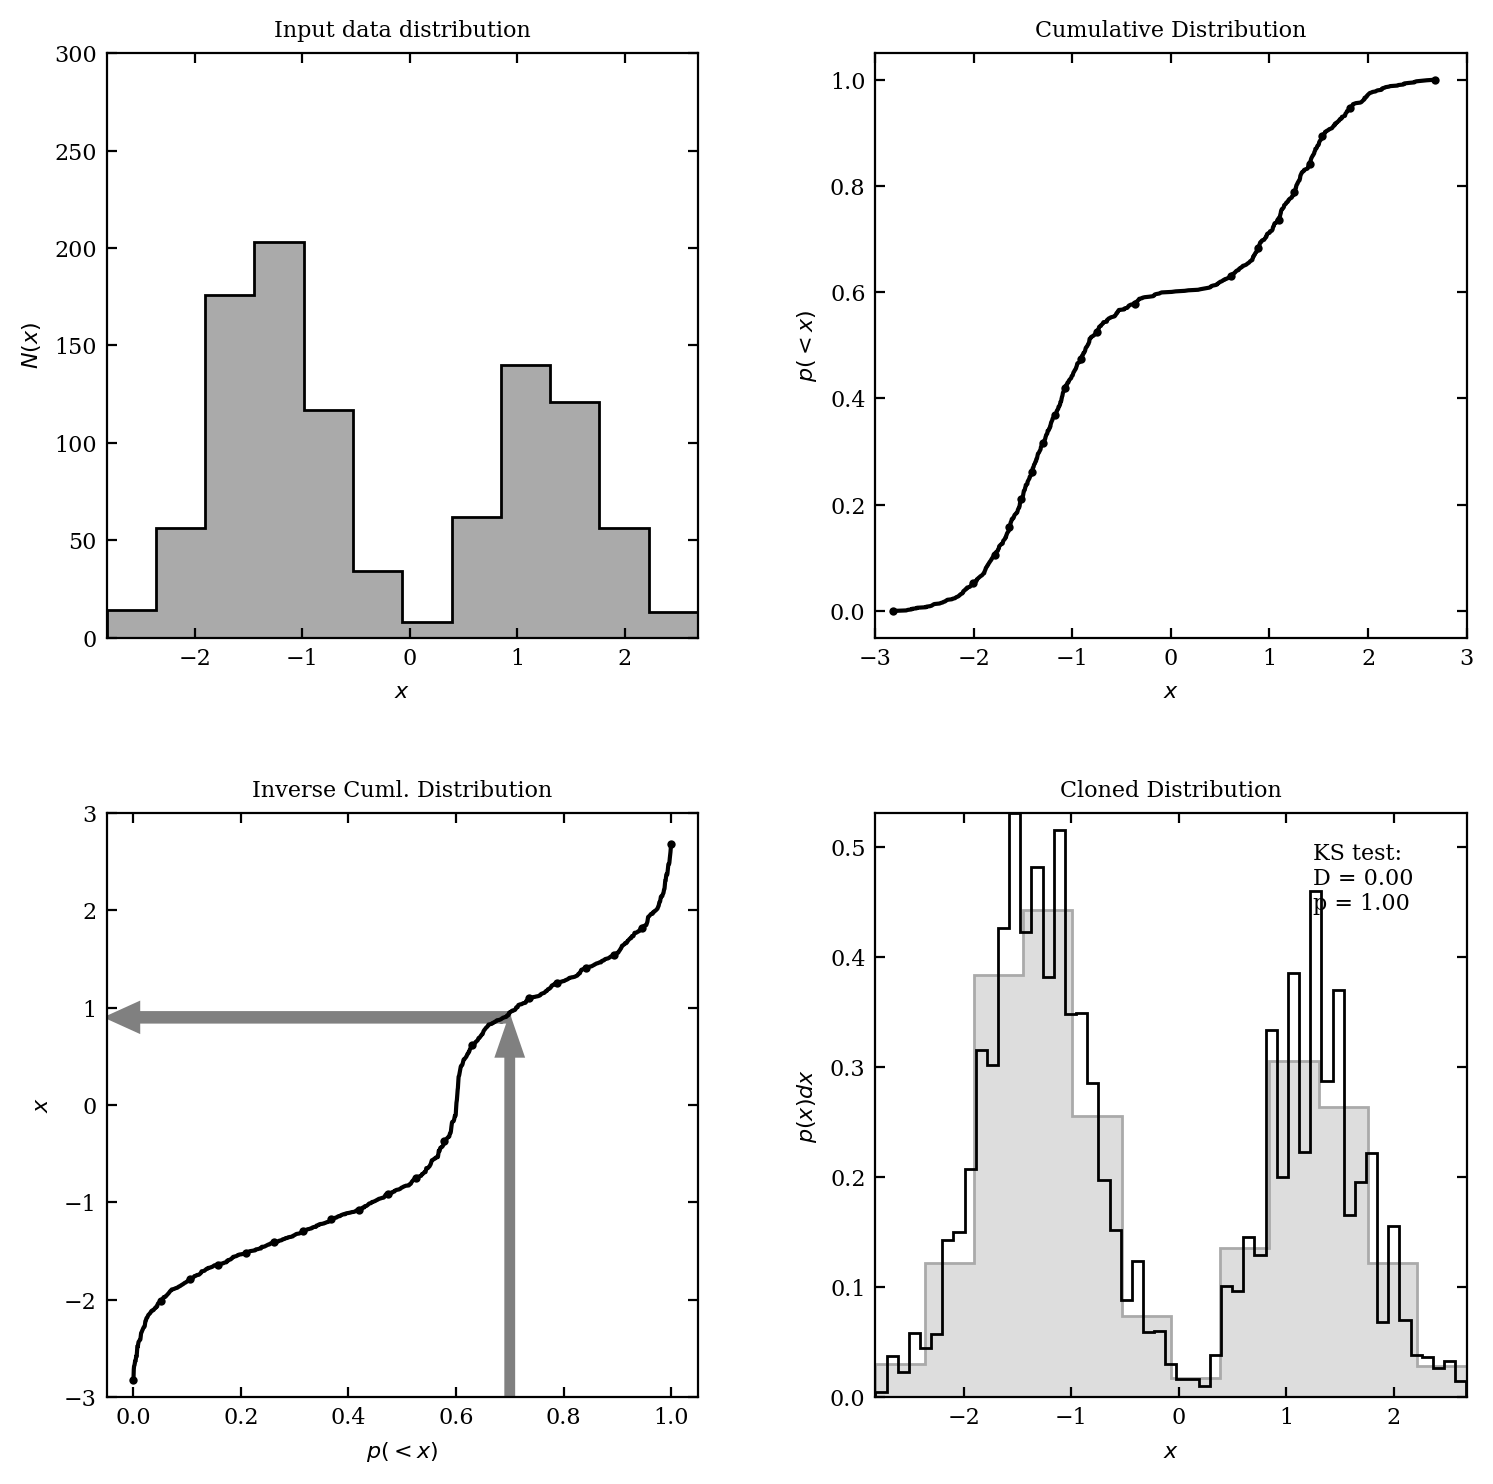

In [12]:
r"""
Random Values from an Empirical Distribution
--------------------------------------------
Figure 3.25.
A demonstration of how to empirically clone a distribution, using a spline
interpolation to approximate the inverse of the observed cumulative
distribution. This allows us to nonparametrically select new random samples
approximating an observed distribution. First the list of points is sorted,
and the rank of each point is used to approximate the cumulative distribution
(upper right). Flipping the axes gives the inverse cumulative distribution on
a regular grid (lower left). After performing a cubic spline fit to the inverse
distribution, a uniformly sampled x value maps to a y value which approximates
the observed pdf. The lower-right panel shows the result. The K-S test
(see section 4.7.2) indicates that the samples are consistent with being
drawn from the same distribution. This method, while fast and effective,
cannot be easily extended to multiple dimensions.
This example uses the routine
:class:`astroML.density_estimation.EmpiricalDistribution`
to clone the distribution
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
from scipy import stats, interpolate
from astropy.visualization import hist
from astroML.density_estimation import EmpiricalDistribution

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Create a distribution and clone it
Ndata = 1000
Nclone = 100000
np.random.seed(0)

# generate an 'observed' bimodal distribution with 10000 values
dists = (stats.norm(-1.3, 0.5), stats.norm(1.3, 0.5))
fracs = (0.6, 0.4)
x = np.hstack((d.rvs(int(f * Ndata)) for d, f in zip(dists, fracs)))

# We can clone the distribution easily with this function
x_cloned = EmpiricalDistribution(x).rvs(Nclone)

# compute the KS test to check if they're the same
D, p = stats.ks_2samp(x, x_cloned)
print("KS test: D = %.2g; p = %.2g" % (D, p))

#------------------------------------------------------------
# For the sake of this example, we need to calculate some
#  of the partial steps used by EmpiricalDistribution

# create a cumulative distribution
x.sort()
Px_cuml = np.linspace(0, 1, Ndata)

# set up an interpolation of the inverse cumulative distribution
tck = interpolate.splrep(Px_cuml, x)

# sample evenly along the cumulative distribution, and interpolate
Px_cuml_sample = np.linspace(0, 1, 10 * Ndata)
x_sample = interpolate.splev(Px_cuml_sample, tck)

#------------------------------------------------------------
# Plot the cloned distribution and the procedure for obtaining it
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.3, left=0.1, right=0.95,
                    bottom=0.08, top=0.92, wspace=0.3)

indices = np.linspace(0, Ndata - 1, 20).astype(int)

# plot a histogram of the input
ax = fig.add_subplot(221)
hist(x, bins='knuth', ax=ax,
     histtype='stepfilled', ec='k', fc='#AAAAAA')
ax.set_ylim(0, 300)
ax.set_title('Input data distribution')
ax.set_xlabel('$x$')
ax.set_ylabel('$N(x)$')

# plot the cumulative distribution
ax = fig.add_subplot(222)
ax.scatter(x[indices], Px_cuml[indices], lw=0, c='k', s=9)
ax.plot(x, Px_cuml, '-k')
ax.set_xlim(-3, 3)
ax.set_ylim(-0.05, 1.05)
ax.set_title('Cumulative Distribution')
ax.set_xlabel('$x$')
ax.set_ylabel('$p(<x)$')

# plot the inverse cumulative distribution and spline fit
ax = fig.add_subplot(223)
ax.scatter(Px_cuml[indices], x[indices], lw=0, c='k', s=9)
ax.plot(Px_cuml_sample, x_sample, '-k')
ax.arrow(0.7, -3, 0, 3.5, width=0.015, fc='gray', ec='gray',
         head_width=0.05, head_length=0.4)
ax.arrow(0.7, 0.9, -0.69, 0, width=0.1, fc='gray', ec='gray',
         head_width=0.3, head_length=0.06)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-3, 3)
ax.set_title('Inverse Cuml. Distribution')
ax.set_xlabel('$p(<x)$')
ax.set_ylabel('$x$')

# plot the resulting cloned distribution
ax = fig.add_subplot(224)
hist(x, bins='knuth', ax=ax,
     histtype='stepfilled', density=True,
     ec='#AAAAAA', fc='#DDDDDD',
     label='input data')
hist(x_cloned, bins='knuth', ax=ax,
     histtype='step', density=True,
     color='k', label='cloned data')
ax.set_title('Cloned Distribution')
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)dx$')
ax.text(0.74, 0.95, "KS test:\nD = %.2f\np = %.2f" % (D, p),
        ha='left', va='top', transform=ax.transAxes)

plt.show()

Let's try this for a simple case. Sample from $$p(x)\propto x$$ between 0 and 10

First, the normalization is important here. 

$$p(x)= \frac{1}{50} x$$

such that $\int p(x) dx=1$ over its domain. 

The cdf is 

First I need to compute the cdf

$$ P(x)= \int_0^x  \frac{1}{50} x' dx' = \frac{x^2}{100} $$

I can now invert this

$$x = \sqrt{100 P}$$

Now it's super easy...

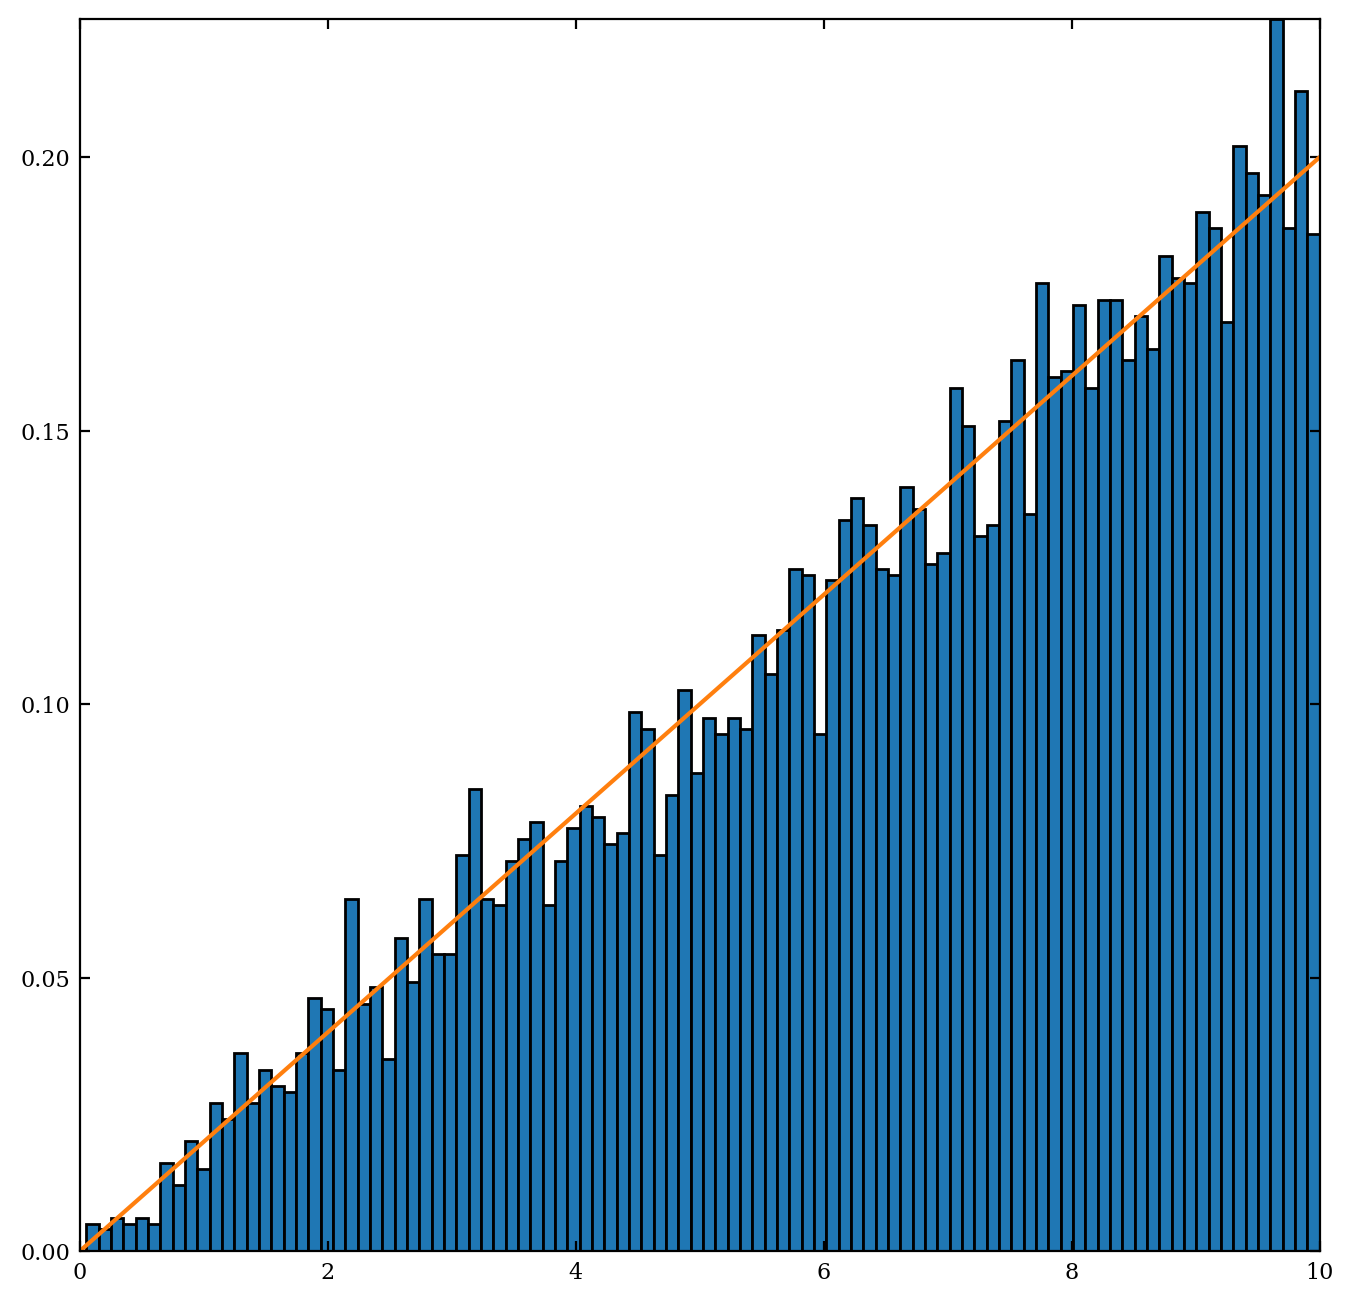

In [13]:
eps = np.random.uniform(0,1,10000)

x = (100*eps)**0.5

plt.hist(x, density=True, bins=100);

xv=np.linspace(0,10,100)
plt.plot(xv, xv/50);

Let's go back to our earlier example. Sample from $$p(x)\propto x+sin(x)$$ between 0 and 10

First I need to compute the cdf

$$ P(x) \propto \int_0^x x'+sin(x') dx' = \frac{1}{2} (2 + x^2 - 2 \cos x) $$

The normalization here is important. One must have $P(x=10)=1$. So:

$$ P(x) = \frac{2 + x^2 - 2 \cos x}{2 + 100 - 2 \cos 10} $$


At this point you need to invert the cdf and get something that looks like $x=f(P)$. In this case, our cdf cannot be inverted analytically. No worries, we'll do it numerically :-) 

In [14]:
x=np.linspace(0,10,100)

def cdf(x):
    return (2 + x**2 - 2*np.cos(x))/(2 + 100 - 2*np.cos(10))

#plt.plot(x,cdf(x))

In [15]:
eps = np.random.uniform(0,1,10000)

# Using a vanilla root finder, which solves for cdf(h)=eps i.e. finds the zero of the function cdf(x)-eps
samples = [ scipy.optimize.brentq(lambda h: cdf(h)-e, 0, 10) for e in eps]

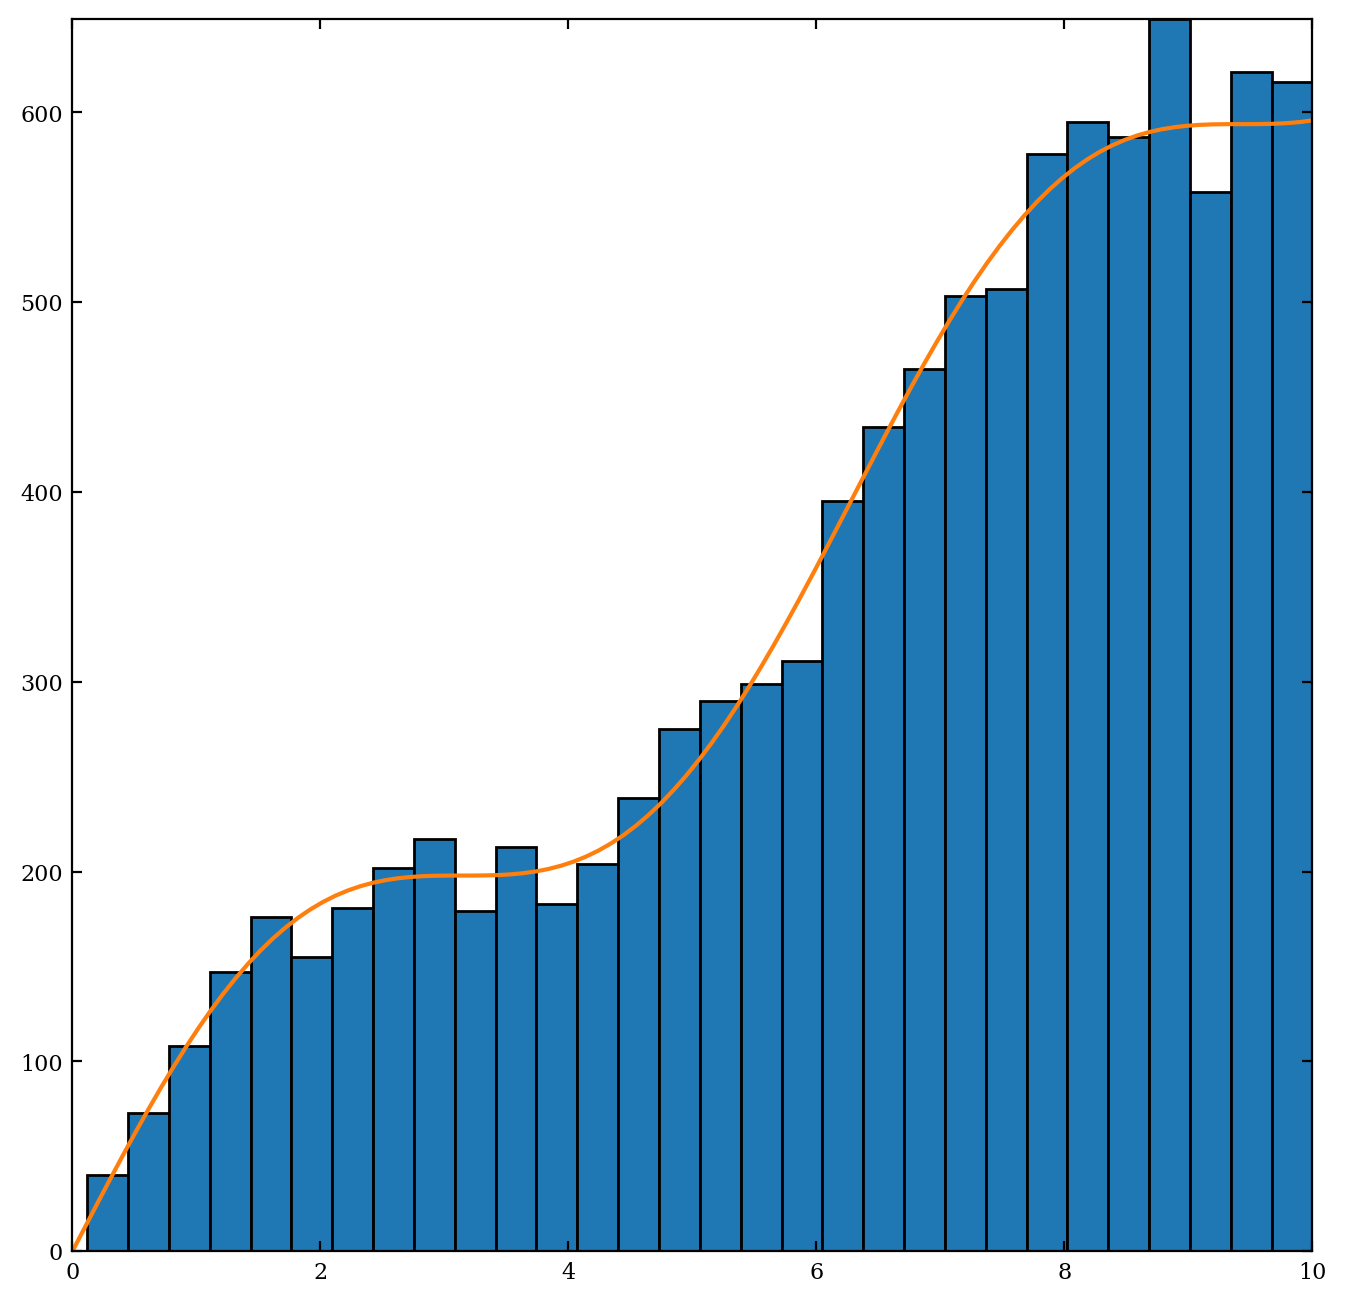

In [16]:
plt.hist(samples,bins=30);


xv=np.linspace(0,10,100)
plt.plot(xv, (xv+np.sin(xv)) * 63); # here I'm so lazy that I normalized it by hand... sorry!

### Cloning or upsample

In the example above we have been sampling from an known function. In most application you don't have this luxury. You're only given datapoints. This called "cloning" or "upsampling", which is: I have samples from a distribution but I'm greedy and I want more. This is crucial in modern stastical application such as bootstrap and jacknife.

# Exam exercise!

## Taking mass out of a black hole

This is an example that comes straight out of my research in general relativity. This is our paper:

**Gerosa, Fabbri, Sperhake (2022)** "*The irreducible mass and the horizon area of LIGO's black holes*" [arxiv:2202.08848](https://arxiv.org/abs/2202.08848) 

(some of the calculations were first worked out by Cecilia Fabbri in her BSc thesis with me).

Consider a rotating black hole. In [1969](https://ui.adsabs.harvard.edu/abs/1969NCimR...1..252P/abstract), Roger Penrose (now [Nobel Prize in Physics](https://www.nobelprize.org/prizes/physics/2020/penrose/facts/) for the theory of black holes) discovered that one can extract energy from a rotating black hole:

![](https://inspirehep.net/files/268d28446b405e134199d84f67c23792)

(figure from [Harada, Kimura 2014](https://ui.adsabs.harvard.edu/abs/2014CQGra..31x3001H/abstract)).

You don't need to understand the details to complete this question but, in brief, rotating black-hole has a region called ergosphere such that infalling particles have negative energy. Penrose imagined a particle that enters that region and decays: half will fall in and half will escape to infinity, carring some energy with it. In a nutshell, we've extracted energy=mass from a black hole! It turns out that one also has to extract angular momentum, not just energy (and here you'll need some General Relativity to understand this calculation, see e.g. the famous textbook by [Misner, Thorne and Weeler](https://press.princeton.edu/books/hardcover/9780691177793/gravitation)). But angular momentum runs our first, such that a repeated series of Penrose processes leaves behind a non-rotating BH with a remnant mass which is called "irreducible". This is a famous result by [Christodoulou (1970)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.25.1596) and is closely related to the even more famous area law by [Hawking (1971)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.26.1344) (which in turns is the foundation of [black-hole thermodynamics](https://en.wikipedia.org/wiki/Black_hole_thermodynamics)).


For a BH of mass $M$ and spin $\chi\in [0,1]$, the irreducible mass is 
\begin{equation}
M_{\rm irr} = %\sqrt{\frac{M^2+\sqrt{M^4-S^2}}{2}} = 
 M \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}}
\label{mirrdef}
\end{equation}
For convenience, let us define $f= M_{\rm irr}/M$

Let's assume that

- the spin $\chi$ is uniformly distributed between 0 and 1.
- the mass $M$ is normally distributed with mean $\mu$ and standard deviation $\sigma$.

These are simplistic assumption that, however, are not too far from [what we are now measuring](https://arxiv.org/abs/2111.03606) with gravitational-wave detectors. It's a toy model, but not a totally unreasonable one.


**Tasks**:

1. First compute the pdf of $f$, that is just a change of variable. We saw how to do this. Verify that the answer is:
\begin{equation}
\pi(f) = 2\frac{2 f^2-1}{\sqrt{1 - f^2}}\,.
\end{equation}


2. Sample this pdf using at least two methods and compare the results.

3. Then compute the pdf of $M_{\rm irr}$. You'll need to use [this theorem](https://en.wikipedia.org/wiki/Distribution_of_the_product_of_two_random_variables) for the product of two random variables. The answer is only semi-analytic (unless you know how to solve that integral? If so please tell me!)
\begin{equation}
p(M_{\rm irr})  = \frac{\sqrt{2/\pi}}{\sigma} \int_{1/\sqrt{2}}^1 \exp\left[{-\frac{(M_{\rm irr}/f -\mu)^2}{2\sigma^2}}\right]  \frac{2 f^2-1}{f \sqrt{1 - f^2}}  \,\, {\rm d}f\,. \label{pmirr}
\end{equation}

4. Sample this pdf using at least two methods and compare the results. Start with a value of $\sigma=0.02$ but then change it and see what happens. Note that $\mu$ is a free scale of the problem and not a parameter: you can normalize all quantities with a dimension of mass by $\mu$ (i.e. it's ok to just set $\mu=1$ in your code provided you remember that all your masses are measured in units of $\mu$). 